In [5]:
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Bidirectional
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from datetime import date, datetime
from multiprocessing.spawn import import_main_path
from keras.preprocessing.sequence import TimeseriesGenerator
from pandas_datareader import data as pdr
import yfinance as yf
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import numpy as np

from keras.callbacks import EarlyStopping
from keras.layers import ConvLSTM2D




# GET DATA

In [6]:
yf.pdr_override()
tickers = ["ANTM.JK","ASII.JK","ICBP.JK","JSMR.JK"]

stock = 'ANTM.JK'
today = date.today()
# print(today)
start_date = '2010-01-01'
# end_date = '2022-08-02'

panel_data = pdr.get_data_yahoo(tickers,start=start_date, end=today)
panel_data.head(5)


[*********************100%***********************]  4 of 4 completed


Adj Close                                               Close  \
                ANTM.JK      ASII.JK      ICBP.JK      JSMR.JK      ANTM.JK   
Date                                                                          
2010-01-04  1576.277344  2421.051025  1408.559082  1530.937866  1931.946777   
2010-01-05  1576.277344  2434.768311  1437.305176  1547.488403  1931.946777   
2010-01-06  1576.277344  2421.051025  1427.723145  1555.763794  1931.946777   
2010-01-07  1610.544312  2345.607422  1437.305176  1547.488403  1973.945557   
2010-01-08  1610.544312  2359.324219  1446.887207  1539.213379  1973.945557   

                                                High          ...     Low  \
           ASII.JK ICBP.JK      JSMR.JK      ANTM.JK ASII.JK  ... ICBP.JK   
Date                                                          ...           
2010-01-04  3530.0  1837.5  1845.677368  1931.946777  3550.0  ...  1762.5   
2010-01-05  3550.0  1875.0  1865.630737  1994.945068  3570.0  ...  1825.0   
2010-01-06  3530.0  1862.5  1875.607300  1994.945068  3580.0  ...  1862.5   
2010-01-07  3420.0  1875.0  1865.630737  1994.945068  3560.0  ...  1862.5   
2010-01-08  3440.0  1887.5  1855.654053  1994.945068  3450.0  ...  1862.5   

                                Open                                 Volume  \
                JSMR.JK      ANTM.JK ASII.JK ICBP.JK      JSMR.JK   ANTM.JK   
Date                                                                          
2010-01-04  1805.770874  1931.946777  3530.0  1787.5  1845.677368  39619544   
2010-01-05  1845.677368  1931.946777  3550.0  1875.0  1865.630737  62041590   
2010-01-06  1855.654053  1931.946777  3530.0  1900.0  1875.607300  30916328   
2010-01-07  1845.677368  1973.945557  3420.0  1875.0  1865.630737  30624653   
2010-01-08  1845.677368  1973.945557  3440.0  1900.0  1855.654053  15857579   

                                       
           ASII.JK   ICBP.JK  JSMR.JK  
Date                                   
2010-01-04      40  26442000  6978806  
2010-01-05      40  42874000  7988164  
2010-01-06      40  44946000  7538113  
2010-01-07      40  24863000  2048787  
2010-01-08      40  19118000  2441705  

[5 rows x 24 columns]

In [7]:
data_close = panel_data["Adj Close"]
list(data_close)
data_close.columns = ['antm', 'asii', 'icbp', 'jsmr']
data_close.describe().apply(lambda s: s.apply('{0:.5f}'.format))

,antm,asii,icbp,jsmr
count,3227.00000,3227.00000,3227.00000,3227.00000
mean,1131.49500,5535.45929,6111.16763,4488.62764
std,576.43457,1102.84227,2826.81368,1157.69198
min,274.09692,2290.73950,1283.99255,1398.53223
25%,740.15723,4964.45996,3957.16943,3770.00000
50%,929.10345,5624.34473,7099.00879,4573.74219
75%,1440.12781,6326.53027,8323.28027,5276.22754
max,3117.91113,7761.65625,11525.49121,6832.19727


# PLOT SEMUA SAHAM

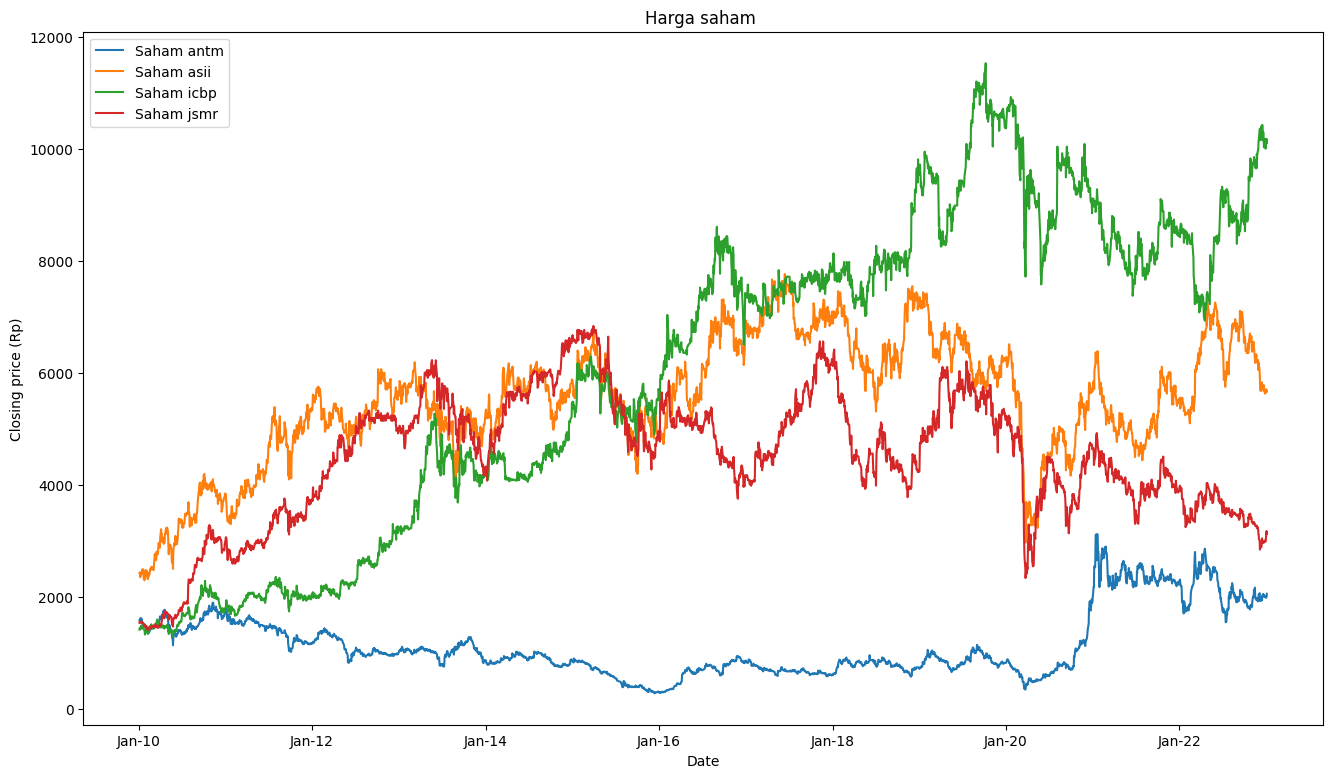

In [8]:
# Plot everything by leveraging the very powerful matplotlib package
fig, ax = plt.subplots(figsize=(16,9))

for name in ['antm', 'asii', 'icbp', 'jsmr']:
    ax.plot(data_close[name].index, data_close[name], label='Saham {}'.format(name))


# Define the date format
date_form = DateFormatter("%b-%y")
ax.xaxis.set_major_formatter(date_form)

ax.set_title('Harga saham ')
ax.set_xlabel('Date')
ax.set_ylabel('Closing price (Rp)')
ax.legend()

# SLIDING WINDOWS

In [9]:
from numpy import array

def split_sequence(seq, n_steps):
    X,y = list(), list()
    for i in range(len(seq)):
        end_ix = i + n_steps
        if end_ix > len(seq)-1:
            break
        seq_x, seq_y =seq[i:end_ix],seq[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

# RESET INDEX

In [10]:
from sklearn.model_selection import train_test_split
def reset_index_data(df_data):
    df_data = df_data.reset_index(drop=True)
    arr_df = df_data.to_numpy()
    flat_df = arr_df.flatten()
    return flat_df

# RESHAPE FUNCT

In [11]:
def reshape_data(X,N_FEATURES):
    X = X.reshape(X.shape[0],X.shape[1],N_FEATURES)
    return X

# PEMBULATAN

In [12]:
def pembulatan(data,number):
    return np.round(data,number)

# METRIC EVALUATION

In [13]:
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score
def matriks_evaluate(preds,y_test, lb_saham, number):
    print('Matriks score for '+ lb_saham)
    print("mae score: "+str(mean_absolute_error(preds, y_test)))
    print("r2 score "+str(r2_score(preds, y_test)))
    print("mape score "+str(mean_absolute_percentage_error(preds, y_test)))
    print("rmse score "+str(np.sqrt(mean_squared_error(preds, y_test))))
    print("round_up")
    print("mae score: "+str(pembulatan(mean_absolute_error(preds, y_test),number)))
    print("r2 score "+str(pembulatan(r2_score(preds, y_test),number)))
    print("mape score "+str(pembulatan(mean_absolute_percentage_error(preds, y_test),number)))
    print("rmse score "+str(pembulatan(np.sqrt(mean_squared_error(preds, y_test)),number)))

# VANILA MODEL

In [14]:
def train_vanila_lstm(X_train,y_train,config):
    #unpach config
    neuron, activation, n_steps, n_features,learning_rate, batch_size,epochs = config
    #define model 
    model_vanila_lstm = Sequential([
    LSTM(neuron, activation=activation,input_shape=(n_steps, n_features)),
    Dense(1),
    ])
    model_vanila_lstm.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss='mean_absolute_error',
    metrics=['mae'],
    )
    early_stopping = EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=20, # how many epochs to wait before stopping
    restore_best_weights=True,
    )

    model_vanila_lstm.summary()
    history_vanila_lstm = model_vanila_lstm.fit(X_train, y_train, validation_split=0.2,
          epochs=epochs,
          batch_size=batch_size,
          callbacks=[early_stopping],
          shuffle = True
    )

    return model_vanila_lstm, history_vanila_lstm

#time 41.8
    

# BIDIRECTIONAL LSTM

In [15]:
def train_bidirectional_lstm(X_train,y_train,config):
    
    #unpach config
    neuron, activation, n_steps, n_features,learning_rate, batch_size,epochs = config
    #define model 
    model_bidirectional_lstm = Sequential([
    Bidirectional(LSTM(neuron, activation=activation),input_shape=(n_steps, n_features)),
    Dense(1),
    ])
    model_bidirectional_lstm.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss='mean_absolute_error',
    metrics=['mae'],
    )
    early_stopping = EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=20, # how many epochs to wait before stopping
    restore_best_weights=True,
    )

    model_bidirectional_lstm.summary()
    history_bidirectional_lstm = model_bidirectional_lstm.fit(X_train, y_train, validation_split=0.2,
          epochs=epochs,
          batch_size=batch_size,
          callbacks=[early_stopping],
          shuffle = True
    )

    return model_bidirectional_lstm, history_bidirectional_lstm

#time 41.8
    

# CNN-LSTM

In [16]:
from keras.layers import Flatten 
from keras.layers import TimeDistributed 
from keras.layers.convolutional import Conv1D 
from keras.layers.convolutional import MaxPooling1D

In [17]:
def train_cnn_lstm(X_train,y_train,config):
    
    #unpach config
    neuron, activation, n_steps,n_features,learning_rate, batch_size,epochs = config
    #define model 
    model_cnn_lstm = Sequential()
    model_cnn_lstm.add(TimeDistributed(Conv1D(64,1,activation=activation), input_shape=(None,n_steps,n_features)))
    model_cnn_lstm.add(TimeDistributed(MaxPooling1D()))
    model_cnn_lstm.add(TimeDistributed(Flatten()))
    model_cnn_lstm.add(LSTM(neuron, activation=activation))
    model_cnn_lstm.add(Dense(1))
    model_cnn_lstm.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss='mean_absolute_error',
    metrics=['mae'],
    )
    early_stopping = EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=20, # how many epochs to wait before stopping
    restore_best_weights=True,
    )

    model_cnn_lstm.summary()
    history_cnn_lstm = model_cnn_lstm.fit(X_train, y_train, validation_split=0.2,
          epochs=epochs,
          batch_size=batch_size,
          callbacks=[early_stopping],
          shuffle = True
    )

    return model_cnn_lstm, history_cnn_lstm

#time 41.8
    

In [18]:
def reshape_data_cnn(X,N_FEATURES, N_SEQ, N_STEPS):
    X = X.reshape(X.shape[0],N_SEQ,N_STEPS,N_FEATURES)
    return X

# CONVLSTM

In [19]:
def train_conv_lstm(X_train,y_train,config):
    
    #unpach config
    neuron, activation, n_steps,n_seq,n_features,learning_rate, batch_size,epochs = config
    #define model 
    model_conv_lstm = Sequential()
    model_conv_lstm.add(ConvLSTM2D(neuron,(1,2),activation=activation, input_shape=(n_seq,1,n_steps,n_features)))
    model_conv_lstm.add(Flatten())
    model_conv_lstm.add(Dense(1))
    model_conv_lstm.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss='mean_absolute_error',
    metrics=['mae'],
    )
    early_stopping = EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=20, # how many epochs to wait before stopping
    restore_best_weights=True,
    )

    model_conv_lstm.summary()
    history_conv_lstm = model_conv_lstm.fit(X_train, y_train, validation_split=0.2,
          epochs=epochs,
          batch_size=batch_size,
          callbacks=[early_stopping],
          shuffle = True
    )

    return model_conv_lstm, history_conv_lstm

#time 41.8
    

In [20]:
def reshape_data_conv(X,N_FEATURES, N_SEQ,N_ROWS, N_STEPS):
    X = X.reshape(X.shape[0],N_SEQ,N_ROWS,N_STEPS,N_FEATURES)
    return X

# RNN

In [21]:

from keras.models import Sequential
from keras.layers import Dense, SimpleRNN

def train_model_rnn(X_train,y_train,config):
    
    #unpach config
    neuron, activation, n_steps, n_features,learning_rate, batch_size,epochs = config
    #define model 
    model_rnn = Sequential([
    SimpleRNN(neuron, activation=activation,input_shape=(n_steps, n_features)),
    Dense(1),
    ])
    model_rnn.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss='mean_absolute_error',
    metrics=['mae'],
    )
    early_stopping = EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=20, # how many epochs to wait before stopping
    restore_best_weights=True,
    )

    model_rnn.summary()
    history_model_rnn = model_rnn.fit(X_train, y_train, validation_split=0.2,
          epochs=epochs,
          batch_size=batch_size,
          callbacks=[early_stopping],
          shuffle = True
    )

    return model_rnn, history_model_rnn

#time 41.8
    

# SPLIT SIZE

In [22]:
def data_size(data):
    train_size = int(len(data) * 0.80)
    test_size = len(data) - train_size
    return train_size, test_size

# STOCK MODELING

## ANTM

### VANILA

In [23]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df_antm = pd.DataFrame(data_close.antm)
df_antm = pd.DataFrame(scaler.fit_transform(df_antm), columns = ['antm'])

In [30]:
#reset index
# df_antm = reset_index_data(df_antm)
antm_train_size, antm_test_size = data_size(df_antm)
train_antm = df_antm.iloc[:antm_train_size,:].values
test_antm = df_antm.iloc[antm_train_size:len(df_antm),:].values


#data to supervised
X_train_antm, y_train_antm = split_sequence(train_antm, 2)
X_test_antm, y_test_antm = split_sequence(test_antm, 2)
        
# X_train_antm, X_test_antm, y_train_antm, y_test_antm = train_test_split(antm_X, antm_y, test_size=0.33, random_state=42)

X_train_antm = reshape_data(X_train_antm,1)
X_test_antm = reshape_data(X_test_antm,1)


In [40]:
antmTestReal = pd.DataFrame(scaler.inverse_transform(test_antm))
antmTestReal.head(10)

,0
0,505.899261
1,510.763641
2,510.763641
3,505.899261
4,515.628113
5,505.899261
6,510.763641
7,520.492554
8,539.950134
9,539.950134


In [25]:
cfg_antm = [8,'relu',2,1,0.1,8,200]
model_antm,history_antm_model,  = train_vanila_lstm(X_train_antm,y_train_antm,cfg_antm)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 8)                 320       
                                                                 
 dense (Dense)               (None, 1)                 9         
                                                                 
Total params: 329
Trainable params: 329
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
258/258 [==============================] - 3s 5ms/step - loss: 0.1111 - mae: 0.1111 - val_loss: 0.1051 - val_mae: 0.1051
Epoch 2/200
258/258 [==============================] - 1s 3ms/step - loss: 0.1104 - mae: 0.1104 - val_loss: 0.0590 - val_mae: 0.0590
Epoch 3/200
258/258 [==============================] - 1s 3ms/step - loss: 0.1147 - mae: 0.1147 - val_loss: 0.0386 - val_mae: 0.0386
Epoch 4/200
258/258 [==============================] - 

In [26]:
preds_antm = model_antm.predict(X_test_antm)
matriks_evaluate(preds_antm,y_test_antm,'antm',4)

21/21 [==============================] - 0s 2ms/step
Matriks score for antm
mae score: 0.40687385758961386
r2 score 0.0
mape score 2.1571281923893553
rmse score 0.4536335272556597
round_up
mae score: 0.4069
r2 score 0.0
mape score 2.1571
rmse score 0.4536


In [27]:
preds_antm_train = model_antm.predict(X_train_antm)
matriks_evaluate(preds_antm_train,y_train_antm,'antm',4)

81/81 [==============================] - 0s 2ms/step
Matriks score for antm
mae score: 0.09235596459129587
r2 score 0.0
mape score 0.4896447664035983
rmse score 0.12603777676495528
round_up
mae score: 0.0924
r2 score 0.0
mape score 0.4896
rmse score 0.126


In [36]:
len(preds_antm)

644

### BILSTM

In [29]:
cfg_antm = [8,'relu',2,1,0.1,8,200]
model_bidirectional_antm,history_antm_model_bidirectional,  = train_bidirectional_lstm(X_train_antm,y_train_antm,cfg_antm)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_1 (Bidirectio  (None, 16)               640       
 nal)                                                            
                                                                 
 dense_2 (Dense)             (None, 1)                 17        
                                                                 
Total params: 657
Trainable params: 657
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
258/258 [==============================] - 4s 5ms/step - loss: 0.0505 - mae: 0.0505 - val_loss: 0.0104 - val_mae: 0.0104
Epoch 2/200
258/258 [==============================] - 1s 4ms/step - loss: 0.0181 - mae: 0.0181 - val_loss: 0.0183 - val_mae: 0.0183
Epoch 3/200
258/258 [==============================] - 1s 4ms/step - loss: 0.0181 - mae: 0.0181 - val_loss: 0.0171 - val

In [ ]:
preds_antm_bidirectional = model_bidirectional_antm.predict(X_test_antm)
matriks_evaluate(preds_antm_bidirectional,y_test_antm,'antm',4)

21/21 [==============================] - 0s 2ms/step
Matriks score for antm
mae score: 0.0281054992525267
r2 score 0.9627472223278134
mape score 0.051700539050135025
rmse score 0.04176050808395509
round_up
mae score: 0.0281
r2 score 0.9627
mape score 0.0517
rmse score 0.0418


In [ ]:
preds_antm_bidirectional_train = model_bidirectional_antm.predict(X_train_antm)
matriks_evaluate(preds_antm_bidirectional_train,y_train_antm,'antm',4)

81/81 [==============================] - 0s 2ms/step
Matriks score for antm
mae score: 0.00796809466669644
r2 score 0.9911750268145438
mape score 0.05643143640910883
rmse score 0.011077969828907103
round_up
mae score: 0.008
r2 score 0.9912
mape score 0.0564
rmse score 0.0111


### CNN-LSTM

In [ ]:
df_antm_cnn = pd.DataFrame(data_close.antm)
df_antm_cnn = pd.DataFrame(scaler.fit_transform(df_antm_cnn), columns = ['antm'])

In [ ]:
antm_train_size_cnn, antm_test_size_cnn = data_size(df_antm_cnn)
train_cnn = df_antm_cnn.iloc[:antm_train_size_cnn,:].values
test_cnn = df_antm_cnn.iloc[antm_train_size_cnn:len(df_antm_cnn),:].values

#data to supervised
X_train_antm_cnn, y_train_antm_cnn = split_sequence(train_cnn, 2)
X_test_antm_cnn, y_test_antm_cnn = split_sequence(test_cnn, 2)
#split to train and test
# X_train_antm_cnn, X_test_antm_cnn, y_train_antm_cnn, y_test_antm_cnn = train_test_split(antm_X_cnn, antm_y_cnn, test_size=0.33, random_state=44)

X_train_antm_cnn = reshape_data_cnn(X_train_antm_cnn,1,1,2)
X_test_antm_cnn = reshape_data_cnn(X_test_antm_cnn,1,1,2)

In [ ]:
cfg_antm_cnn = [8,'relu',2,1,0.01,8,200]
model_cnn_antm,history_cnn_antm_model = train_cnn_lstm(X_train_antm_cnn,y_train_antm_cnn,cfg_antm_cnn)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, None, 2, 64)      128       
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, None, 1, 64)      0         
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, None, 64)         0         
 tributed)                                                       
                                                                 
 lstm_2 (LSTM)               (None, 8)                 2336      
                                                                 
 dense_2 (Dense)             (None, 1)                 9         
                                                      

In [ ]:
preds_antm_cnn_lstm = model_cnn_antm.predict(X_test_antm_cnn)
matriks_evaluate(preds_antm_cnn_lstm,y_test_antm_cnn,'antm',4)

21/21 [==============================] - 0s 2ms/step
Matriks score for antm
mae score: 0.026240217622395527
r2 score 0.9738126739971745
mape score 0.04275713738237729
rmse score 0.03937833830818724
round_up
mae score: 0.0262
r2 score 0.9738
mape score 0.0428
rmse score 0.0394


In [ ]:
preds_antm_cnn_lstm_train = model_cnn_antm.predict(X_train_antm_cnn)
matriks_evaluate(preds_antm_cnn_lstm_train,y_train_antm_cnn,'antm',4)

81/81 [==============================] - 0s 2ms/step
Matriks score for antm
mae score: 0.007309062330892261
r2 score 0.9926279973552394
mape score 0.04505262245471461
rmse score 0.01002293796716702
round_up
mae score: 0.0073
r2 score 0.9926
mape score 0.0451
rmse score 0.01


### CONVLSTM

In [ ]:
df_antm_conv = pd.DataFrame(data_close.antm)
df_antm_conv = pd.DataFrame(scaler.fit_transform(df_antm_conv), columns = ['antm'])

In [ ]:
antm_train_size_conv, antm_test_size_conv = data_size(df_antm_conv)
train_conv = df_antm_conv.iloc[:antm_train_size,:].values
test_conv = df_antm_conv.iloc[antm_train_size:len(df_antm),:].values

#data to supervised
X_train_antm_conv, y_train_antm_conv = split_sequence(train_conv, 2)
X_test_antm_conv, y_test_antm_conv = split_sequence(test_conv, 2)

X_train_antm_conv = reshape_data_conv(X_train_antm_conv,1,1,1,2)
X_test_antm_conv = reshape_data_conv(X_test_antm_conv,1,1,1,2)

In [ ]:
cfg_antm_conv = [8,'relu',2,1,1,0.1,8,200]
model_conv_antm,history_conv_antm_model,  = train_conv_lstm(X_train_antm_conv,y_train_antm_conv,cfg_antm_conv)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d (ConvLSTM2D)    (None, 1, 1, 8)           608       
                                                                 
 flatten_1 (Flatten)         (None, 8)                 0         
                                                                 
 dense_3 (Dense)             (None, 1)                 9         
                                                                 
Total params: 617
Trainable params: 617
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
258/258 [==============================] - 5s 6ms/step - loss: 0.0325 - mae: 0.0325 - val_loss: 0.0460 - val_mae: 0.0460
Epoch 2/200
258/258 [==============================] - 1s 5ms/step - loss: 0.0236 - mae: 0.0236 - val_loss: 0.0077 - val_mae: 0.0077
Epoch 3/200
258/258 [==============================] -

In [ ]:
preds_antm_conv_lstm = model_conv_antm.predict(X_test_antm_conv)
matriks_evaluate(preds_antm_conv_lstm,y_test_antm_conv,'antm',4)

21/21 [==============================] - 0s 2ms/step
Matriks score for antm
mae score: 0.019606943623294116
r2 score 0.9845795273496399
mape score 0.03694802983970519
rmse score 0.02903887331175146
round_up
mae score: 0.0196
r2 score 0.9846
mape score 0.0369
rmse score 0.029


In [ ]:
preds_antm_conv_lstm_train = model_conv_antm.predict(X_train_antm_conv)
matriks_evaluate(preds_antm_conv_lstm_train,y_train_antm_conv,'antm',4)

81/81 [==============================] - 0s 2ms/step
Matriks score for antm
mae score: 0.008499695443733551
r2 score 0.9900105626923736
mape score 0.05885143480768178
rmse score 0.011514380515961799
round_up
mae score: 0.0085
r2 score 0.99
mape score 0.0589
rmse score 0.0115


### RNN

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df_antm_rnn = pd.DataFrame(data_close.antm)
df_antm_rnn = pd.DataFrame(scaler.fit_transform(df_antm_rnn), columns = ['antm'])

In [ ]:
antm_rnn_train_size, antm_rnn_test_size = data_size(df_antm_rnn)
train_rnn = df_antm_rnn.iloc[:antm_rnn_train_size,:].values
test_rnn = df_antm_rnn.iloc[antm_rnn_train_size:len(df_antm_rnn),:].values

#data to supervised
X_train_antm_rnn, y_train_antm_rnn = split_sequence(train_rnn, 2)
X_test_antm_rnn, y_test_antm_rnn = split_sequence(test_rnn, 2)

X_train_antm_rnn = reshape_data(X_train_antm_rnn,1)
X_test_antm_rnn = reshape_data(X_test_antm_rnn,1)


In [ ]:
cfg_antm_rnn = [8,'relu',2,1,0.1,8,200]
model_antm_rnn,history_antm_model_rnn  = train_model_rnn(X_train_antm_rnn,y_train_antm_rnn,cfg_antm_rnn)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 8)                 80        
                                                                 
 dense_4 (Dense)             (None, 1)                 9         
                                                                 
Total params: 89
Trainable params: 89
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
258/258 [==============================] - 2s 3ms/step - loss: 0.0259 - mae: 0.0259 - val_loss: 0.0140 - val_mae: 0.0140
Epoch 2/200
258/258 [==============================] - 1s 3ms/step - loss: 0.0249 - mae: 0.0249 - val_loss: 0.0136 - val_mae: 0.0136
Epoch 3/200
258/258 [==============================] - 1s 3ms/step - loss: 0.0277 - mae: 0.0277 - val_loss: 0.0099 - val_mae: 0.0099
Epoch 4/200
258/258 [==============================] - 

In [ ]:
preds_antm_rnn = model_antm_rnn.predict(X_test_antm_rnn)
matriks_evaluate(preds_antm_rnn,y_test_antm_rnn,'antm',4)

21/21 [==============================] - 0s 1ms/step
Matriks score for antm
mae score: 0.023587963727203686
r2 score 0.9815132873127582
mape score 0.04126957164367485
rmse score 0.032448512322250295
round_up
mae score: 0.0236
r2 score 0.9815
mape score 0.0413
rmse score 0.0324


In [ ]:
preds_antm_rnn_train = model_antm_rnn.predict(X_train_antm_rnn)
matriks_evaluate(preds_antm_rnn_train,y_train_antm_rnn,'antm',4)

81/81 [==============================] - 0s 2ms/step
Matriks score for antm
mae score: 0.007354081237074331
r2 score 0.9929241744387224
mape score 0.0542102845933137
rmse score 0.010186965907343047
round_up
mae score: 0.0074
r2 score 0.9929
mape score 0.0542
rmse score 0.0102


### PLOT DATA SAHAM

In [ ]:
date = pd.DataFrame(data_close.antm.index)
train_date_antm = pd.DataFrame(date.iloc[2:antm_train_size,:].values)
test_date_antm = pd.DataFrame(date.iloc[antm_train_size:len(df_antm)-2,:].values)
#VANILA
train_plot_antm = pd.DataFrame(scaler.inverse_transform(preds_antm_train), columns=['antm'])
test_plot_antm = pd.DataFrame(scaler.inverse_transform(preds_antm), columns=['antm'])
#BILSTM
train_plot_antm_bilstm = pd.DataFrame(scaler.inverse_transform(preds_antm_bidirectional_train), columns=['antm'])
test_plot_antm_bilstm = pd.DataFrame(scaler.inverse_transform(preds_antm_bidirectional), columns=['antm'])
#CNN-LSTM
train_plot_antm_cnnlstm = pd.DataFrame(scaler.inverse_transform(preds_antm_cnn_lstm_train), columns=['antm'])
test_plot_antm_cnnlstm = pd.DataFrame(scaler.inverse_transform(preds_antm_cnn_lstm), columns=['antm'])
#CONV-LSTM
train_plot_antm_conv = pd.DataFrame(scaler.inverse_transform(preds_antm_conv_lstm_train), columns=['antm'])
test_plot_antm_conv = pd.DataFrame(scaler.inverse_transform(preds_antm_conv_lstm), columns=['antm'])
#RNN
train_plot_antm_rnn = pd.DataFrame(scaler.inverse_transform(preds_antm_rnn_train), columns=['antm'])
test_plot_antm_rnn = pd.DataFrame(scaler.inverse_transform(preds_antm_rnn), columns=['antm'])


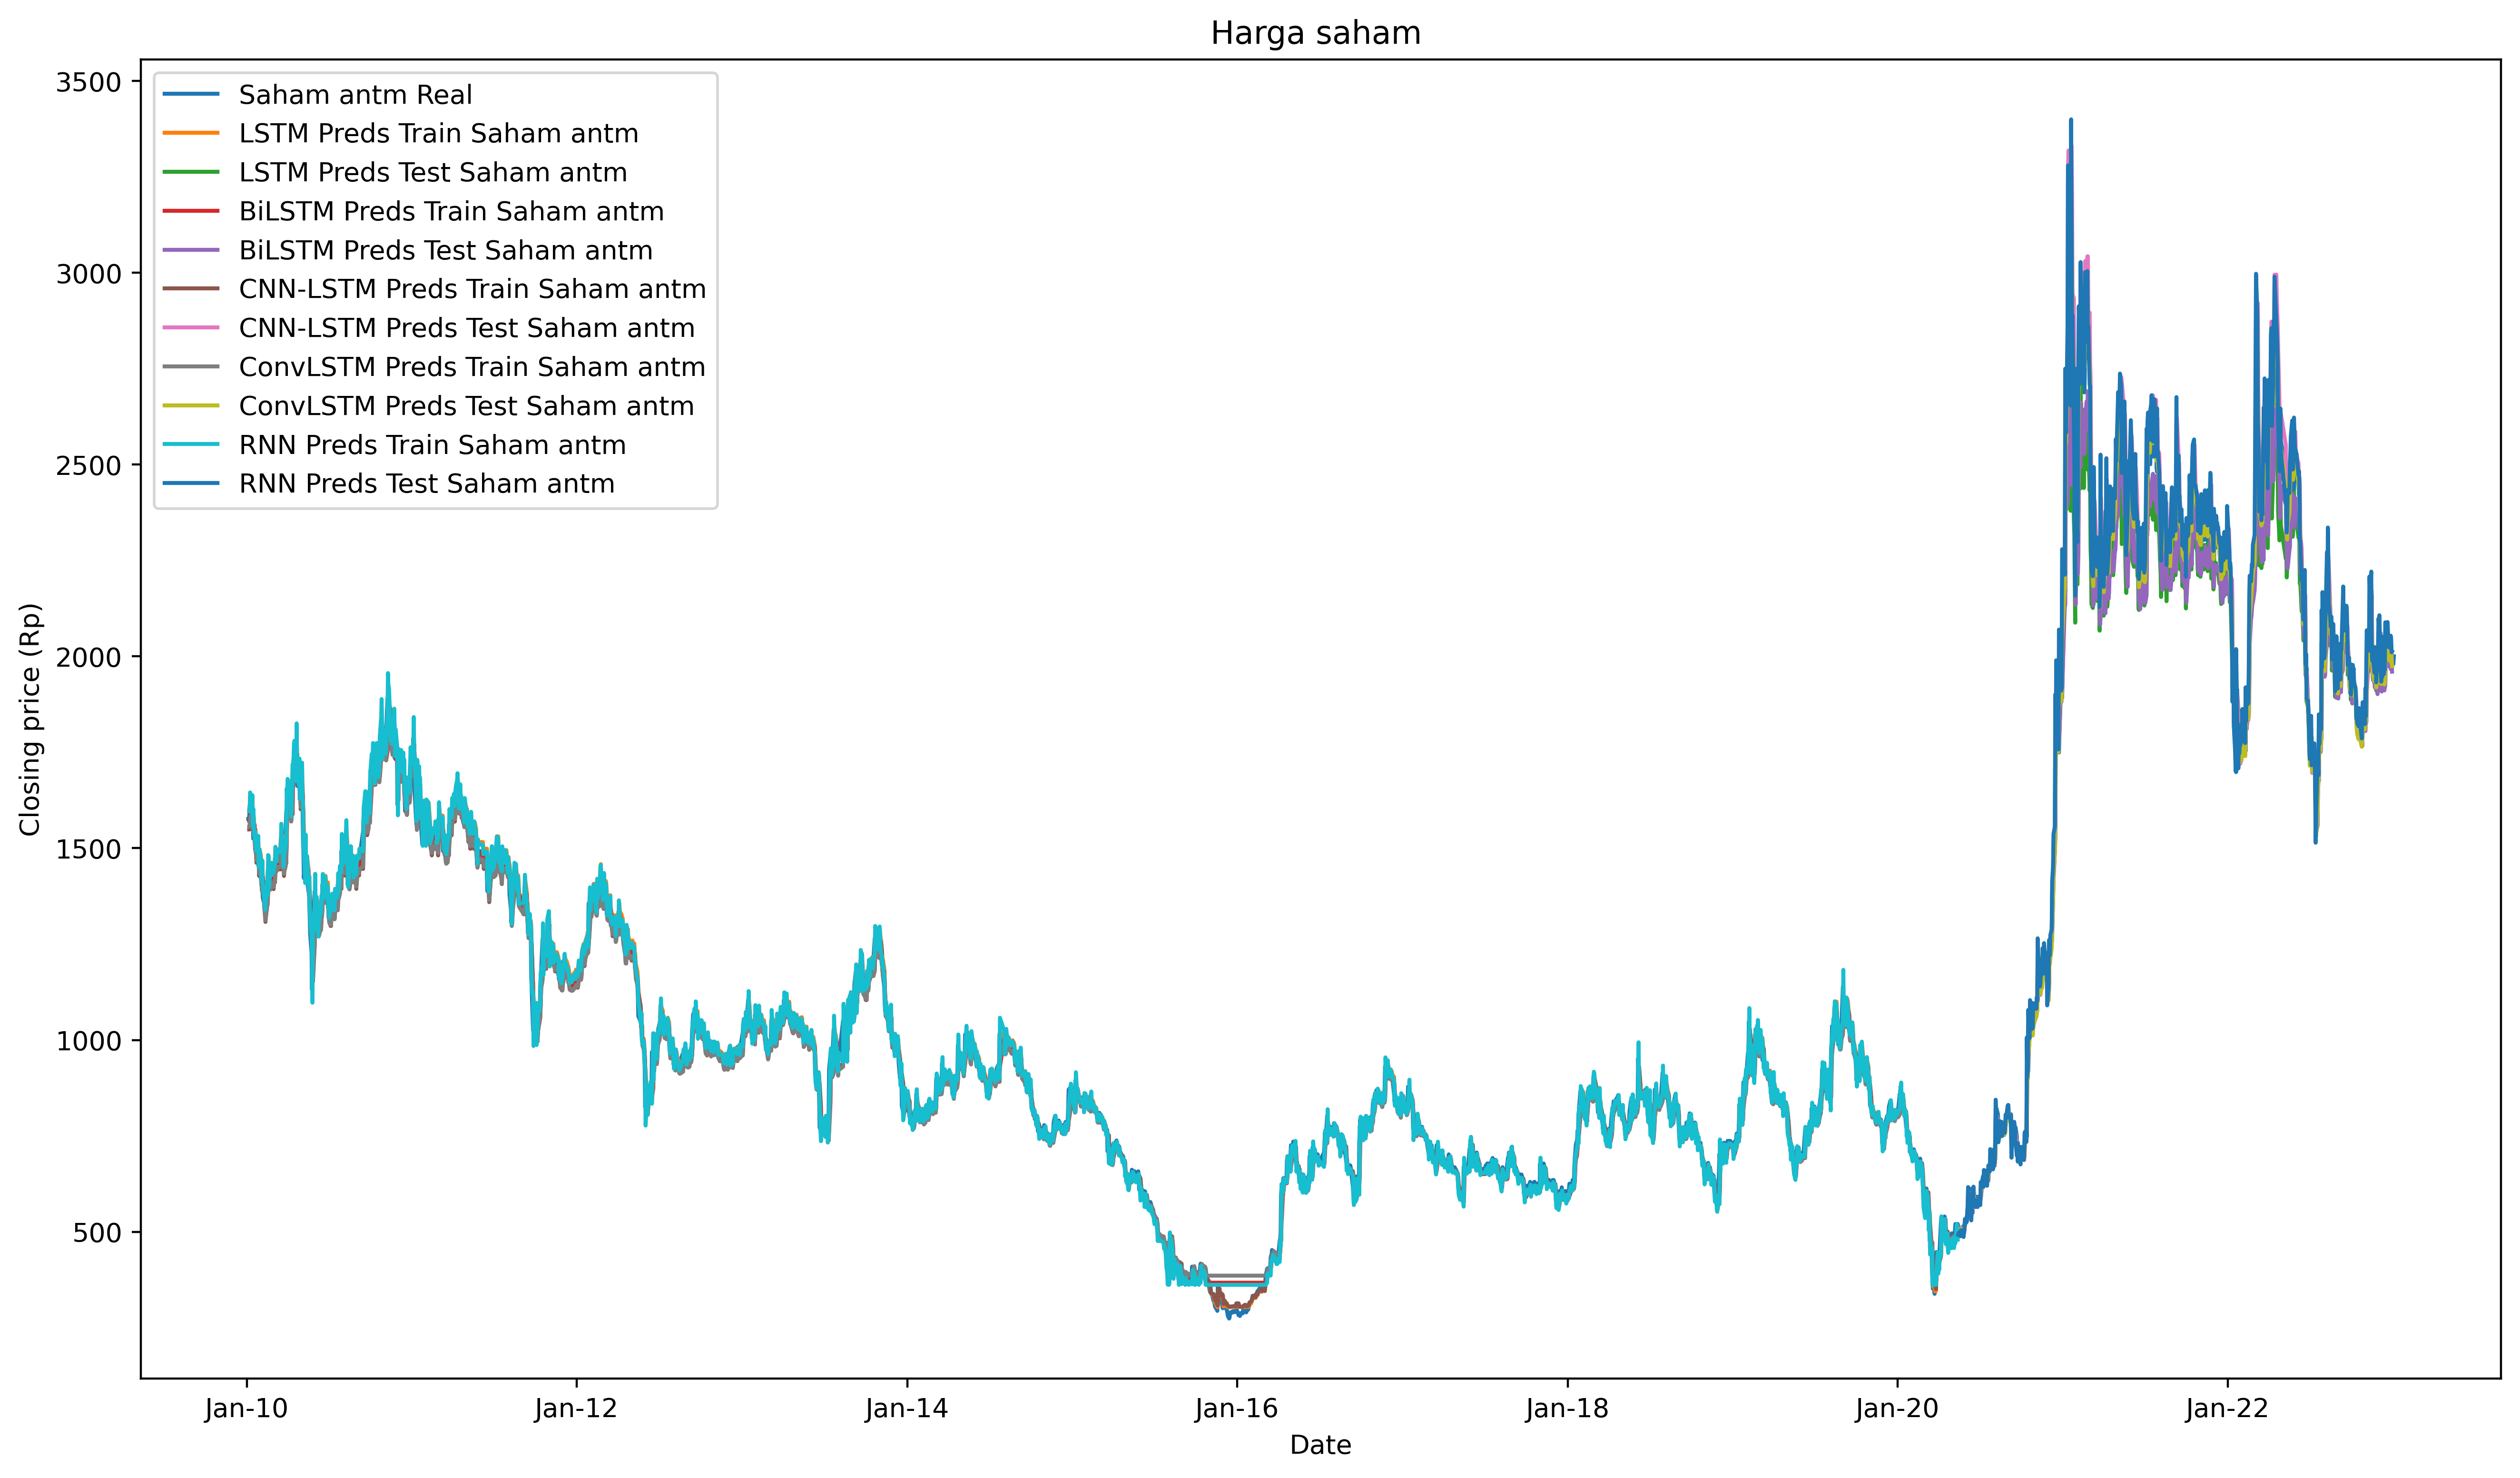

In [ ]:
# Plot everything by leveraging the very powerful matplotlib package
fig, ax = plt.subplots(figsize=(16,9), dpi=400)
name = 'antm'
ax.plot(data_close.antm.index, data_close.antm, label='Saham {} Real'.format(name))
#VANILA LSTM
ax.plot(train_date_antm, train_plot_antm, label='LSTM Preds Train Saham {}'.format(name))
ax.plot(test_date_antm, test_plot_antm, label='LSTM Preds Test Saham {}'.format(name))
#BILSTM
ax.plot(train_date_antm, train_plot_antm_bilstm, label='BiLSTM Preds Train Saham {}'.format(name))
ax.plot(test_date_antm, test_plot_antm_bilstm, label='BiLSTM Preds Test Saham {}'.format(name))
#CNN-LSTM
ax.plot(train_date_antm, train_plot_antm_cnnlstm, label='CNN-LSTM Preds Train Saham {}'.format(name))
ax.plot(test_date_antm, test_plot_antm_cnnlstm, label='CNN-LSTM Preds Test Saham {}'.format(name))
#CONVLSTM
ax.plot(train_date_antm, train_plot_antm_conv, label='ConvLSTM Preds Train Saham {}'.format(name))
ax.plot(test_date_antm, test_plot_antm_conv, label='ConvLSTM Preds Test Saham {}'.format(name))
#RNN
ax.plot(train_date_antm, train_plot_antm_rnn, label='RNN Preds Train Saham {}'.format(name))
ax.plot(test_date_antm, test_plot_antm_rnn, label='RNN Preds Test Saham {}'.format(name))

# Define the date format
date_form = DateFormatter("%b-%y")
ax.xaxis.set_major_formatter(date_form)

ax.set_title('Harga saham ')
ax.set_xlabel('Date')
ax.set_ylabel('Closing price (Rp)')
ax.legend()

In [ ]:
antmReal = pd.DataFrame()
antmReal["lstm"] = test_plot_antm
antmReal["bilstm"] = test_plot_antm_bilstm 
antmReal["cnnstm"] = test_plot_antm_cnnlstm 
antmReal["convlstm"] = test_plot_antm_conv 
antmReal["rnn"] = test_plot_antm_rnn
antmReal.head(10)

,lstm,bilstm,cnnstm,convlstm,rnn
0,492.503296,493.031433,500.264801,500.035278,492.440735
1,497.362274,497.732697,504.992615,504.652283,497.464966
2,498.791168,500.699249,504.992615,506.725769,495.505859
3,495.367310,498.961304,504.992615,504.182343,488.522491
4,500.800446,499.473724,509.716187,507.197052,504.448456
5,496.797455,501.937714,509.716187,506.254913,486.563354
6,497.362274,497.732697,504.992615,504.652283,497.464966
7,505.674011,504.177795,514.435364,511.817505,509.472748
8,522.403687,517.074829,533.270020,526.168884,533.488281
9,528.034180,529.024658,533.270020,534.458252,525.651855


## ASII

### VANILLA

In [41]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df_asii = pd.DataFrame(data_close.asii)
df_asii = pd.DataFrame(scaler.fit_transform(df_asii), columns = ['asii'])

In [42]:
#reset index
# df_asii = reset_index_data(df_asii)

asii_train_size, asii_test_size = data_size(df_asii)
train_asii = df_asii.iloc[:asii_train_size,:].values
test_asii = df_asii.iloc[asii_train_size:len(df_asii),:].values


#data to supervised
X_train_asii, y_train_asii = split_sequence(train_asii, 3)
X_test_asii, y_test_asii = split_sequence(test_asii, 3)
        
# X_train_asii, X_test_asii, y_train_asii, y_test_asii = train_test_split(asii_X, asii_y, test_size=0.33, random_state=42)

X_train_asii = reshape_data(X_train_asii,1)
X_test_asii = reshape_data(X_test_asii,1)


In [43]:
asiiTestReal = pd.DataFrame(scaler.inverse_transform(test_asii))
asiiTestReal.head(10)

,0
0,3353.061035
1,3533.819336
2,3569.970703
3,3588.046387
4,3913.411377
5,3931.486816
6,4103.206543
7,4311.078125
8,4274.926758
9,4419.534180


In [ ]:
cfg_asii = [32,'relu',3,1,0.01,8,150]
model_asii,history_asii_model,  = train_vanila_lstm(X_train_asii,y_train_asii,cfg_asii)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 32)                4352      
                                                                 
 dense_5 (Dense)             (None, 1)                 33        
                                                                 
Total params: 4,385
Trainable params: 4,385
Non-trainable params: 0
_________________________________________________________________
Epoch 1/150
258/258 [==============================] - 3s 5ms/step - loss: 0.0451 - mae: 0.0451 - val_loss: 0.0269 - val_mae: 0.0269
Epoch 2/150
258/258 [==============================] - 1s 4ms/step - loss: 0.0233 - mae: 0.0233 - val_loss: 0.0199 - val_mae: 0.0199
Epoch 3/150
258/258 [==============================] - 1s 6ms/step - loss: 0.0210 - mae: 0.0210 - val_loss: 0.0287 - val_mae: 0.0287
Epoch 4/150
258/258 [============================

In [ ]:
preds_asii = model_asii.predict(X_test_asii)
matriks_evaluate(preds_asii,y_test_asii,'asii',4)

21/21 [==============================] - 0s 2ms/step
Matriks score for asii
mae score: 0.015322897371052663
r2 score 0.9797167265727618
mape score 0.026956376136032145
rmse score 0.020237026174781104
round_up
mae score: 0.0153
r2 score 0.9797
mape score 0.027
rmse score 0.0202


In [ ]:
preds_asii_train = model_asii.predict(X_train_asii)
matriks_evaluate(preds_asii_train,y_train_asii,'asii',4)

81/81 [==============================] - 0s 3ms/step
Matriks score for asii
mae score: 0.014769679257600603
r2 score 0.9909787217136955
mape score 0.03423712918388795
rmse score 0.019985053234343006
round_up
mae score: 0.0148
r2 score 0.991
mape score 0.0342
rmse score 0.02


### BILSTM

In [ ]:
cfg_asii = [32,'relu',3,1,0.01,8,150]
model_bidirectional_asii,history_asii_model_bidirectional,  = train_bidirectional_lstm(X_train_asii,y_train_asii,cfg_asii)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_1 (Bidirectio  (None, 64)               8704      
 nal)                                                            
                                                                 
 dense_6 (Dense)             (None, 1)                 65        
                                                                 
Total params: 8,769
Trainable params: 8,769
Non-trainable params: 0
_________________________________________________________________
Epoch 1/150
258/258 [==============================] - 6s 7ms/step - loss: 0.0440 - mae: 0.0440 - val_loss: 0.0263 - val_mae: 0.0263
Epoch 2/150
258/258 [==============================] - 1s 4ms/step - loss: 0.0271 - mae: 0.0271 - val_loss: 0.0212 - val_mae: 0.0212
Epoch 3/150
258/258 [==============================] - 1s 4ms/step - loss: 0.0245 - mae: 0.0245 - val_loss: 0.0364 -

In [ ]:
preds_asii_bidirectional = model_bidirectional_asii.predict(X_test_asii)
matriks_evaluate(preds_asii_bidirectional,y_test_asii,'asii',4)

21/21 [==============================] - 1s 2ms/step
Matriks score for asii
mae score: 0.015607872922677957
r2 score 0.9794036917552826
mape score 0.02726724947546328
rmse score 0.020451712930054385
round_up
mae score: 0.0156
r2 score 0.9794
mape score 0.0273
rmse score 0.0205


In [ ]:
preds_asii_bidirectional_train = model_bidirectional_asii.predict(X_train_asii)
matriks_evaluate(preds_asii_bidirectional_train,y_train_asii,'asii',4)

81/81 [==============================] - 0s 3ms/step
Matriks score for asii
mae score: 0.014991875463698168
r2 score 0.9907639933225817
mape score 0.03420876505869851
rmse score 0.020234262950772578
round_up
mae score: 0.015
r2 score 0.9908
mape score 0.0342
rmse score 0.0202


### CNN-LSTM

In [ ]:
df_asii_cnn = pd.DataFrame(data_close.asii)
df_asii_cnn = pd.DataFrame(scaler.fit_transform(df_asii_cnn), columns = ['asii'])

In [ ]:
asii_train_size_cnn, asii_test_size_cnn = data_size(df_asii_cnn)
train_cnn_asii = df_asii_cnn.iloc[:asii_train_size_cnn,:].values
test_cnn_asii = df_asii_cnn.iloc[asii_train_size_cnn:len(df_asii_cnn),:].values

#data to supervised
X_train_asii_cnn, y_train_asii_cnn = split_sequence(train_cnn_asii, 3)
X_test_asii_cnn, y_test_asii_cnn = split_sequence(test_cnn_asii, 3)
#split to train and test
# X_train_asii_cnn, X_test_asii_cnn, y_train_asii_cnn, y_test_asii_cnn = train_test_split(asii_X_cnn, asii_y_cnn, test_size=0.33, random_state=44)

X_train_asii_cnn = reshape_data_cnn(X_train_asii_cnn,1,1,3)
X_test_asii_cnn = reshape_data_cnn(X_test_asii_cnn,1,1,3)

In [ ]:
cfg_asii_cnn = [32,'relu',3,1,0.1,8,150]
model_cnn_asii,history_cnn_asii_model,  = train_cnn_lstm(X_train_asii_cnn,y_train_asii_cnn,cfg_asii_cnn)

Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_30 (TimeDi  (None, None, 3, 64)      128       
 stributed)                                                      
                                                                 
 time_distributed_31 (TimeDi  (None, None, 1, 64)      0         
 stributed)                                                      
                                                                 
 time_distributed_32 (TimeDi  (None, None, 64)         0         
 stributed)                                                      
                                                                 
 lstm_18 (LSTM)              (None, 32)                12416     
                                                                 
 dense_27 (Dense)            (None, 1)                 33        
                                                     

In [ ]:
preds_asii_cnn_lstm = model_cnn_asii.predict(X_test_asii_cnn)
matriks_evaluate(preds_asii_cnn_lstm,y_test_asii_cnn,'asii',4)

21/21 [==============================] - 0s 2ms/step
Matriks score for asii
mae score: 0.026447590003214068
r2 score 0.9294168256534814
mape score 0.047270829414000515
rmse score 0.03377356773782233
round_up
mae score: 0.0264
r2 score 0.9294
mape score 0.0473
rmse score 0.0338


In [ ]:
preds_asii_cnn_lstm_train = model_cnn_asii.predict(X_train_asii_cnn)
matriks_evaluate(preds_asii_cnn_lstm_train,y_train_asii_cnn,'asii',4)

81/81 [==============================] - 0s 3ms/step
Matriks score for asii
mae score: 0.029874373779605928
r2 score 0.9537800130174462
mape score 0.07076594454222047
rmse score 0.04065955514864245
round_up
mae score: 0.0299
r2 score 0.9538
mape score 0.0708
rmse score 0.0407


### CONVLSTM

In [ ]:
df_asii_conv = pd.DataFrame(data_close.asii)
df_asii_conv = pd.DataFrame(scaler.fit_transform(df_asii_conv), columns = ['asii'])

In [ ]:
asii_train_size_conv, asii_test_size_conv = data_size(df_asii_conv)
train_conv_asii = df_asii_conv.iloc[:asii_train_size,:].values
test_conv_asii = df_asii_conv.iloc[asii_train_size:len(df_asii_conv),:].values

#data to supervised
X_train_asii_conv, y_train_asii_conv = split_sequence(train_conv_asii, 3)
X_test_asii_conv, y_test_asii_conv = split_sequence(test_conv_asii, 3)

X_train_asii_conv = reshape_data_conv(X_train_asii_conv,1,1,1,3)
X_test_asii_conv = reshape_data_conv(X_test_asii_conv,1,1,1,3)

In [ ]:
cfg_asii_conv = [32,'relu',3,1,1,0.1,8,150]
model_conv_asii,history_conv_asii_model,  = train_conv_lstm(X_train_asii_conv,y_train_asii_conv,cfg_asii_conv)

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d_1 (ConvLSTM2D)  (None, 1, 2, 32)          8576      
                                                                 
 flatten_3 (Flatten)         (None, 64)                0         
                                                                 
 dense_8 (Dense)             (None, 1)                 65        
                                                                 
Total params: 8,641
Trainable params: 8,641
Non-trainable params: 0
_________________________________________________________________
Epoch 1/150
258/258 [==============================] - 5s 6ms/step - loss: 0.0728 - mae: 0.0728 - val_loss: 0.1226 - val_mae: 0.1226
Epoch 2/150
258/258 [==============================] - 1s 4ms/step - loss: 0.0382 - mae: 0.0382 - val_loss: 0.0238 - val_mae: 0.0238
Epoch 3/150
258/258 [=============================

In [ ]:
preds_asii_conv_lstm = model_conv_asii.predict(X_test_asii_conv)
matriks_evaluate(preds_asii_conv_lstm,y_test_asii_conv,'asii',4)

21/21 [==============================] - 0s 2ms/step
Matriks score for asii
mae score: 0.015371961651621555
r2 score 0.9800588889220492
mape score 0.027258922150619903
rmse score 0.020428110901879577
round_up
mae score: 0.0154
r2 score 0.9801
mape score 0.0273
rmse score 0.0204


In [ ]:
preds_asii_conv_lstm_train = model_conv_asii.predict(X_train_asii_conv)
matriks_evaluate(preds_asii_conv_lstm_train,y_train_asii_conv,'asii',4)

81/81 [==============================] - 0s 2ms/step
Matriks score for asii
mae score: 0.016855743934096272
r2 score 0.9869672710950383
mape score 0.044420765378345724
rmse score 0.023627870107645235
round_up
mae score: 0.0169
r2 score 0.987
mape score 0.0444
rmse score 0.0236


### RNN

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df_asii_rnn = pd.DataFrame(data_close.asii)
df_asii_rnn = pd.DataFrame(scaler.fit_transform(df_asii_rnn), columns = ['asii'])

In [ ]:
asii_rnn_train_size, asii_rnn_test_size = data_size(df_asii_rnn)
train_rnn_asii = df_asii_rnn.iloc[:asii_rnn_train_size,:].values
test_rnn_asii = df_asii_rnn.iloc[asii_rnn_train_size:len(df_asii_rnn),:].values

#data to supervised
X_train_asii_rnn, y_train_asii_rnn = split_sequence(train_rnn_asii, 3)
X_test_asii_rnn, y_test_asii_rnn = split_sequence(test_rnn_asii, 3)

X_train_asii_rnn = reshape_data(X_train_asii_rnn,1)
X_test_asii_rnn = reshape_data(X_test_asii_rnn,1)


In [ ]:
cfg_asii_rnn = [32,'relu',3,1,0.01,8,150]
model_asii_rnn,history_asii_model_rnn  = train_model_rnn(X_train_asii_rnn,y_train_asii_rnn,cfg_asii_rnn)

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_1 (SimpleRNN)    (None, 32)                1088      
                                                                 
 dense_9 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1,121
Trainable params: 1,121
Non-trainable params: 0
_________________________________________________________________
Epoch 1/150
258/258 [==============================] - 2s 4ms/step - loss: 0.0288 - mae: 0.0288 - val_loss: 0.0283 - val_mae: 0.0283
Epoch 2/150
258/258 [==============================] - 1s 2ms/step - loss: 0.0198 - mae: 0.0198 - val_loss: 0.0170 - val_mae: 0.0170
Epoch 3/150
258/258 [==============================] - 1s 2ms/step - loss: 0.0182 - mae: 0.0182 - val_loss: 0.0170 - val_mae: 0.0170
Epoch 4/150
258/258 [============================

In [ ]:
preds_asii_rnn = model_asii_rnn.predict(X_test_asii_rnn)
matriks_evaluate(preds_asii_rnn,y_test_asii_rnn,'asii',4)

21/21 [==============================] - 0s 1ms/step
Matriks score for asii
mae score: 0.015810390638181872
r2 score 0.980072880823659
mape score 0.02836932933729825
rmse score 0.020807200679016608
round_up
mae score: 0.0158
r2 score 0.9801
mape score 0.0284
rmse score 0.0208


In [ ]:
preds_asii_rnn_train = model_asii_rnn.predict(X_train_asii_rnn)
matriks_evaluate(preds_asii_rnn_train,y_train_asii_rnn,'asii',4)

81/81 [==============================] - 0s 1ms/step
Matriks score for asii
mae score: 0.015489039796974259
r2 score 0.9906699200076933
mape score 0.03773306749557102
rmse score 0.020810034957705253
round_up
mae score: 0.0155
r2 score 0.9907
mape score 0.0377
rmse score 0.0208


### PLOT DATA SAHAM ASII

In [ ]:
date = pd.DataFrame(data_close.asii.index)
train_date_asii = pd.DataFrame(date.iloc[3:asii_train_size,:].values)
test_date_asii = pd.DataFrame(date.iloc[asii_train_size:len(df_asii)-3,:].values)
#VANILA
train_plot_asii = pd.DataFrame(scaler.inverse_transform(preds_asii_train), columns=['asii'])
test_plot_asii = pd.DataFrame(scaler.inverse_transform(preds_asii), columns=['asii'])
#BILSTM
train_plot_asii_bilstm = pd.DataFrame(scaler.inverse_transform(preds_asii_bidirectional_train), columns=['asii'])
test_plot_asii_bilstm = pd.DataFrame(scaler.inverse_transform(preds_asii_bidirectional), columns=['asii'])
#CNN-LSTM
train_plot_asii_cnnlstm = pd.DataFrame(scaler.inverse_transform(preds_asii_cnn_lstm_train), columns=['asii'])
test_plot_asii_cnnlstm = pd.DataFrame(scaler.inverse_transform(preds_asii_cnn_lstm), columns=['asii'])
#CONV-LSTM
train_plot_asii_conv = pd.DataFrame(scaler.inverse_transform(preds_asii_conv_lstm_train), columns=['asii'])
test_plot_asii_conv = pd.DataFrame(scaler.inverse_transform(preds_asii_conv_lstm), columns=['asii'])
#RNN
train_plot_asii_rnn = pd.DataFrame(scaler.inverse_transform(preds_asii_rnn_train), columns=['asii'])
test_plot_asii_rnn = pd.DataFrame(scaler.inverse_transform(preds_asii_rnn), columns=['asii'])


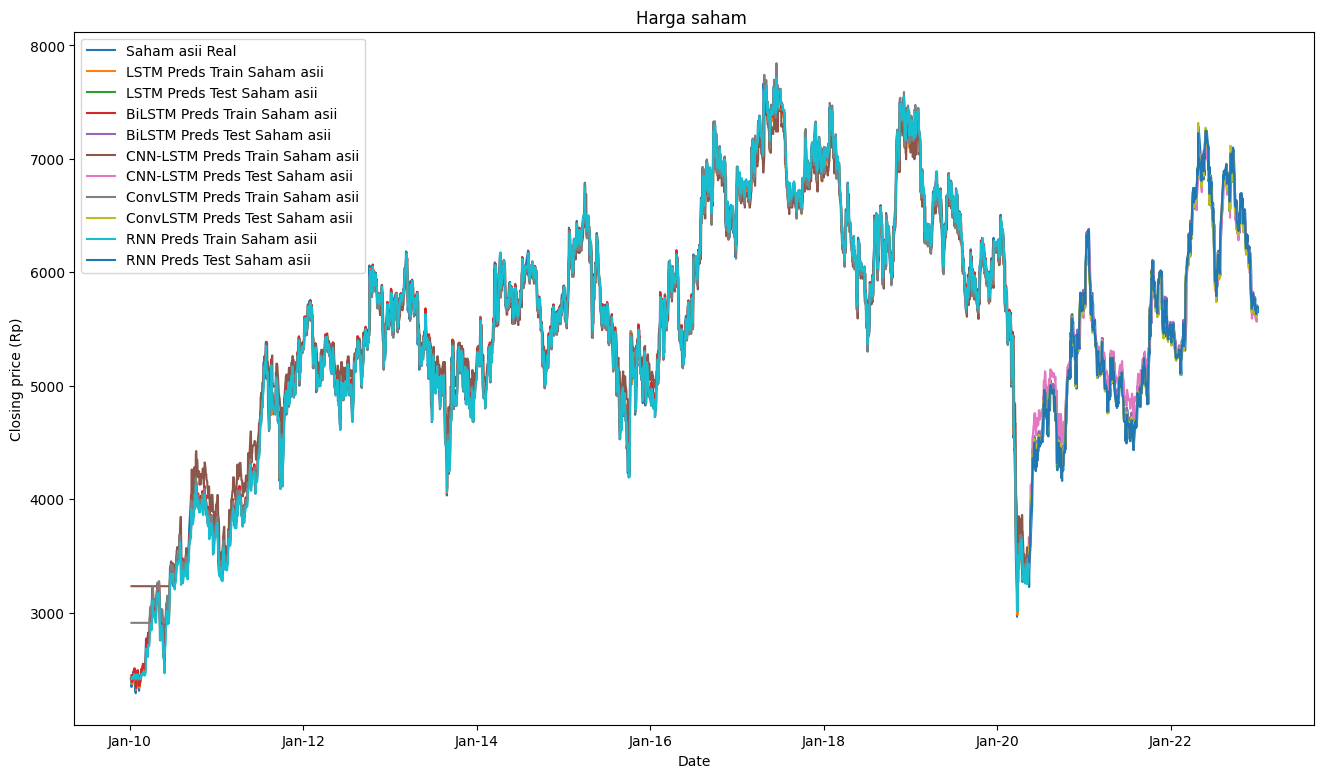

In [ ]:
# Plot everything by leveraging the very powerful matplotlib package
fig, ax = plt.subplots(figsize=(16,9))
name = 'asii'
ax.plot(data_close.asii.index, data_close.asii, label='Saham {} Real'.format(name))
#VANILA LSTM
ax.plot(train_date_asii, train_plot_asii, label='LSTM Preds Train Saham {}'.format(name))
ax.plot(test_date_asii, test_plot_asii, label='LSTM Preds Test Saham {}'.format(name))
#BILSTM
ax.plot(train_date_asii, train_plot_asii_bilstm, label='BiLSTM Preds Train Saham {}'.format(name))
ax.plot(test_date_asii, test_plot_asii_bilstm, label='BiLSTM Preds Test Saham {}'.format(name))
#CNN-LSTM
ax.plot(train_date_asii, train_plot_asii_cnnlstm, label='CNN-LSTM Preds Train Saham {}'.format(name))
ax.plot(test_date_asii, test_plot_asii_cnnlstm, label='CNN-LSTM Preds Test Saham {}'.format(name))
#CONVLSTM
ax.plot(train_date_asii, train_plot_asii_conv, label='ConvLSTM Preds Train Saham {}'.format(name))
ax.plot(test_date_asii, test_plot_asii_conv, label='ConvLSTM Preds Test Saham {}'.format(name))
#RNN
ax.plot(train_date_asii, train_plot_asii_rnn, label='RNN Preds Train Saham {}'.format(name))
ax.plot(test_date_asii, test_plot_asii_rnn, label='RNN Preds Test Saham {}'.format(name))

# Define the date format
date_form = DateFormatter("%b-%y")
ax.xaxis.set_major_formatter(date_form)

ax.set_title('Harga saham ')
ax.set_xlabel('Date')
ax.set_ylabel('Closing price (Rp)')
ax.legend()

In [ ]:
asiiReal = pd.DataFrame()
asiiReal["LSTM"] = test_plot_asii
asiiReal["BiLSTM"] = test_plot_asii_bilstm 
asiiReal["CNN-LSTM"] = test_plot_asii_cnnlstm 
asiiReal["ConvLSTM"] = test_plot_asii_conv 
asiiReal["RNN"] = test_plot_asii_rnn
asiiReal.head(10)

,LSTM,BiLSTM,CNN-LSTM,ConvLSTM,RNN
0,3543.334229,3548.503174,6288.190918,3520.075684,3448.898438
1,3577.782715,3576.430908,6288.190918,3589.408203,3506.995850
2,3598.346680,3607.556885,6288.190918,3610.723389,3546.203369
3,3925.809570,3922.011230,6288.190918,3861.032715,3800.791260
4,3937.777832,3924.565674,6288.190918,3944.072510,3839.842529
5,4119.690430,4124.530762,6288.190918,4080.169922,4018.692139
6,4319.722656,4308.146484,6288.190918,4278.074707,4194.548828
7,4287.263672,4295.099609,6288.190918,4283.905273,4225.796387
8,4439.381348,4442.337402,6288.190918,4395.213867,4359.789062
9,4316.845703,4333.892090,6288.190918,4323.719727,4288.220703


## ICBP

### VANILLA

In [44]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df_icbp = pd.DataFrame(data_close.icbp)
df_icbp = pd.DataFrame(scaler.fit_transform(df_icbp), columns = ['icbp'])

In [46]:
#reset index
# df_icbp = reset_index_data(df_icbp)

icbp_train_size, icbp_test_size = data_size(df_icbp)
train_icbp = df_icbp.iloc[:icbp_train_size,:].values
test_icbp = df_icbp.iloc[icbp_train_size:len(df_icbp),:].values


#data to supervised
X_train_icbp, y_train_icbp = split_sequence(train_icbp, 1)
X_test_icbp, y_test_icbp = split_sequence(test_icbp, 1)
        
# X_train_icbp, X_test_icbp, y_train_icbp, y_test_icbp = train_test_split(icbp_X, icbp_y, test_size=0.33, random_state=42)

X_train_icbp = reshape_data(X_train_icbp,1)
X_test_icbp = reshape_data(X_test_icbp,1)


In [47]:
icbpTestReal = pd.DataFrame(scaler.inverse_transform(test_icbp))
icbpTestReal.head(10)

,0
0,9015.909180
1,9039.145508
2,9201.802734
3,8922.961914
4,8318.802734
5,7737.880371
6,7737.880371
7,7575.222168
8,7877.302246
9,7900.538086


In [ ]:
# neuron, activation, n_steps, n_features,learning_rate, batch_size,epochs
cfg_icbp = [8,'relu',1,1,0.01,16,200]
model_icbp,history_icbp_model,  = train_vanila_lstm(X_train_icbp,y_train_icbp,cfg_icbp)

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 8)                 320       
                                                                 
 dense_10 (Dense)            (None, 1)                 9         
                                                                 
Total params: 329
Trainable params: 329
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
129/129 [==============================] - 2s 5ms/step - loss: 0.0895 - mae: 0.0895 - val_loss: 0.0953 - val_mae: 0.0953
Epoch 2/200
129/129 [==============================] - 0s 3ms/step - loss: 0.0153 - mae: 0.0153 - val_loss: 0.0688 - val_mae: 0.0688
Epoch 3/200
129/129 [==============================] - 0s 2ms/step - loss: 0.0115 - mae: 0.0115 - val_loss: 0.0398 - val_mae: 0.0398
Epoch 4/200
129/129 [==============================]

In [ ]:
preds_icbp = model_icbp.predict(X_test_icbp)
matriks_evaluate(preds_icbp,y_test_icbp,'icbp',4)

21/21 [==============================] - 0s 2ms/step
Matriks score for icbp
mae score: 0.010095298477890471
r2 score 0.9608932085061733
mape score 0.014115364282501854
rmse score 0.013960523856215825
round_up
mae score: 0.0101
r2 score 0.9609
mape score 0.0141
rmse score 0.014


In [ ]:
preds_icbp_train = model_icbp.predict(X_train_icbp)
matriks_evaluate(preds_icbp_train,y_train_icbp,'icbp',4)

81/81 [==============================] - 0s 2ms/step
Matriks score for icbp
mae score: 0.007636176550774572
r2 score 0.9983220283788655
mape score 0.03722310455253799
rmse score 0.011134363215861857
round_up
mae score: 0.0076
r2 score 0.9983
mape score 0.0372
rmse score 0.0111


### BILSTM

In [ ]:
# neuron, activation, n_steps, n_features,learning_rate, batch_size,epochs
cfg_icbp = [8,'relu',1,1,0.01,16,200]
model_bidirectional_icbp,history_icbp_model_bidirectional,  = train_bidirectional_lstm(X_train_icbp,y_train_icbp,cfg_icbp)

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_2 (Bidirectio  (None, 16)               640       
 nal)                                                            
                                                                 
 dense_11 (Dense)            (None, 1)                 17        
                                                                 
Total params: 657
Trainable params: 657
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
129/129 [==============================] - 3s 6ms/step - loss: 0.0596 - mae: 0.0596 - val_loss: 0.0748 - val_mae: 0.0748
Epoch 2/200
129/129 [==============================] - 0s 3ms/step - loss: 0.0112 - mae: 0.0112 - val_loss: 0.0160 - val_mae: 0.0160
Epoch 3/200
129/129 [==============================] - 0s 3ms/step - loss: 0.0080 - mae: 0.0080 - val_loss: 0.0116 - va

In [ ]:
preds_icbp_bidirectional = model_bidirectional_icbp.predict(X_test_icbp)
matriks_evaluate(preds_icbp_bidirectional,y_test_icbp,'icbp',4)

21/21 [==============================] - 0s 1ms/step
Matriks score for icbp
mae score: 0.009922327976258295
r2 score 0.9615704474658557
mape score 0.01395469257702884
rmse score 0.013847856367373575
round_up
mae score: 0.0099
r2 score 0.9616
mape score 0.014
rmse score 0.0138


In [ ]:
preds_icbp_bidirectional_train = model_bidirectional_icbp.predict(X_train_icbp)
matriks_evaluate(preds_icbp_bidirectional_train,y_train_icbp,'icbp',4)

81/81 [==============================] - 0s 2ms/step
Matriks score for icbp
mae score: 0.006967124164510147
r2 score 0.9984159393776096
mape score 0.031624953704254985
rmse score 0.010782273194075471
round_up
mae score: 0.007
r2 score 0.9984
mape score 0.0316
rmse score 0.0108


### CNN-LSTM

In [ ]:
df_icbp_cnn = pd.DataFrame(data_close.icbp)
df_icbp_cnn = pd.DataFrame(scaler.fit_transform(df_icbp_cnn), columns = ['icbp'])

In [ ]:
icbp_train_size_cnn, icbp_test_size_cnn = data_size(df_icbp_cnn)
train_cnn_icbp = df_icbp_cnn.iloc[:icbp_train_size,:].values
test_cnn_icbp = df_icbp_cnn.iloc[icbp_train_size:len(df_icbp_cnn),:].values

#data to supervised
X_train_icbp_cnn, y_train_icbp_cnn = split_sequence(train_cnn_icbp, 2)
X_test_icbp_cnn, y_test_icbp_cnn = split_sequence(test_cnn_icbp, 2)
#split to train and test
# X_train_icbp_cnn, X_test_icbp_cnn, y_train_icbp_cnn, y_test_icbp_cnn = train_test_split(icbp_X_cnn, icbp_y_cnn, test_size=0.33, random_state=44)

X_train_icbp_cnn = reshape_data_cnn(X_train_icbp_cnn,1,1,2)
X_test_icbp_cnn = reshape_data_cnn(X_test_icbp_cnn,1,1,2)

In [ ]:
cfg_icbp_cnn = [8,'relu',2,1,0.1,16,200]
model_cnn_icbp,history_cnn_icbp_model,  = train_cnn_lstm(X_train_icbp_cnn,y_train_icbp_cnn,cfg_icbp_cnn)

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_6 (TimeDis  (None, None, 2, 64)      128       
 tributed)                                                       
                                                                 
 time_distributed_7 (TimeDis  (None, None, 1, 64)      0         
 tributed)                                                       
                                                                 
 time_distributed_8 (TimeDis  (None, None, 64)         0         
 tributed)                                                       
                                                                 
 lstm_8 (LSTM)               (None, 8)                 2336      
                                                                 
 dense_12 (Dense)            (None, 1)                 9         
                                                     

In [ ]:
preds_icbp_cnn_lstm = model_cnn_icbp.predict(X_test_icbp_cnn)
matriks_evaluate(preds_icbp_cnn_lstm,y_test_icbp_cnn,'icbp',4)

21/21 [==============================] - 0s 2ms/step
Matriks score for icbp
mae score: 0.013652159595145956
r2 score 0.9133226427096852
mape score 0.018911257846034108
rmse score 0.018229656934351624
round_up
mae score: 0.0137
r2 score 0.9133
mape score 0.0189
rmse score 0.0182


In [ ]:
preds_icbp_cnn_lstm_train = model_cnn_icbp.predict(X_train_icbp_cnn)
matriks_evaluate(preds_icbp_cnn_lstm_train,y_train_icbp_cnn,'icbp',4)

81/81 [==============================] - 0s 2ms/step
Matriks score for icbp
mae score: 0.02493876393459319
r2 score 0.989667601976362
mape score 1.6831073230329727
rmse score 0.0291054025526839
round_up
mae score: 0.0249
r2 score 0.9897
mape score 1.6831
rmse score 0.0291


### CONVLSTM

In [ ]:
df_icbp_conv = pd.DataFrame(data_close.icbp)
df_icbp_conv = pd.DataFrame(scaler.fit_transform(df_icbp_conv), columns = ['icbp'])

In [ ]:
icbp_train_size_conv, icbp_test_size_conv = data_size(df_icbp_conv)
train_conv_icbp = df_icbp_conv.iloc[:icbp_train_size,:].values
test_conv_icbp = df_icbp_conv.iloc[icbp_train_size:len(df_icbp),:].values

#data to supervised
X_train_icbp_conv, y_train_icbp_conv = split_sequence(train_conv_icbp, 2)
X_test_icbp_conv, y_test_icbp_conv = split_sequence(test_conv_icbp, 2)

X_train_icbp_conv = reshape_data_conv(X_train_icbp_conv,1,1,1,2)
X_test_icbp_conv = reshape_data_conv(X_test_icbp_conv,1,1,1,2)

In [ ]:
cfg_icbp_conv = [8,'relu',2,1,1,0.1,16,200]
model_conv_icbp,history_conv_icbp_model,  = train_conv_lstm(X_train_icbp_conv,y_train_icbp_conv,cfg_icbp_conv)

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d_2 (ConvLSTM2D)  (None, 1, 1, 8)           608       
                                                                 
 flatten_5 (Flatten)         (None, 8)                 0         
                                                                 
 dense_13 (Dense)            (None, 1)                 9         
                                                                 
Total params: 617
Trainable params: 617
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
129/129 [==============================] - 6s 7ms/step - loss: 0.0425 - mae: 0.0425 - val_loss: 0.0160 - val_mae: 0.0160
Epoch 2/200
129/129 [==============================] - 0s 4ms/step - loss: 0.0235 - mae: 0.0235 - val_loss: 0.0862 - val_mae: 0.0862
Epoch 3/200
129/129 [==============================] 

In [ ]:
preds_icbp_conv_lstm = model_conv_icbp.predict(X_test_icbp_conv)
matriks_evaluate(preds_icbp_conv_lstm,y_test_icbp_conv,'icbp',4)

21/21 [==============================] - 0s 2ms/step
Matriks score for icbp
mae score: 0.009809181924580529
r2 score 0.9607358008974994
mape score 0.013765796881343334
rmse score 0.013796407219086388
round_up
mae score: 0.0098
r2 score 0.9607
mape score 0.0138
rmse score 0.0138


In [ ]:
preds_icbp_conv_lstm_train = model_conv_icbp.predict(X_train_icbp_conv)
matriks_evaluate(preds_icbp_conv_lstm_train,y_train_icbp_conv,'icbp',4)

81/81 [==============================] - 0s 2ms/step
Matriks score for icbp
mae score: 0.015192913567828873
r2 score 0.9950368354463933
mape score 0.10675793020195018
rmse score 0.01847682794184273
round_up
mae score: 0.0152
r2 score 0.995
mape score 0.1068
rmse score 0.0185


### RNN

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df_icbp_rnn = pd.DataFrame(data_close.icbp)
df_icbp_rnn = pd.DataFrame(scaler.fit_transform(df_icbp_rnn), columns = ['icbp'])

In [ ]:
icbp_rnn_train_size, icbp_rnn_test_size = data_size(df_icbp_rnn)
train_rnn = df_icbp_rnn.iloc[:icbp_rnn_train_size,:].values
test_rnn = df_icbp_rnn.iloc[icbp_rnn_train_size:len(df_icbp_rnn),:].values

#data to supervised
X_train_icbp_rnn, y_train_icbp_rnn = split_sequence(train_rnn, 1)
X_test_icbp_rnn, y_test_icbp_rnn = split_sequence(test_rnn, 1)

X_train_icbp_rnn = reshape_data(X_train_icbp_rnn,1)
X_test_icbp_rnn = reshape_data(X_test_icbp_rnn,1)


In [ ]:
cfg_icbp_rnn = [8,'relu',1,1,0.01,16,200]
model_icbp_rnn,history_icbp_model_rnn  = train_model_rnn(X_train_icbp_rnn,y_train_icbp_rnn,cfg_icbp_rnn)

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_2 (SimpleRNN)    (None, 8)                 80        
                                                                 
 dense_14 (Dense)            (None, 1)                 9         
                                                                 
Total params: 89
Trainable params: 89
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
129/129 [==============================] - 2s 4ms/step - loss: 0.0205 - mae: 0.0205 - val_loss: 0.0168 - val_mae: 0.0168
Epoch 2/200
129/129 [==============================] - 0s 3ms/step - loss: 0.0074 - mae: 0.0074 - val_loss: 0.0125 - val_mae: 0.0125
Epoch 3/200
129/129 [==============================] - 0s 2ms/step - loss: 0.0072 - mae: 0.0072 - val_loss: 0.0102 - val_mae: 0.0102
Epoch 4/200
129/129 [==============================] -

In [ ]:
preds_icbp_rnn = model_icbp_rnn.predict(X_test_icbp_rnn)
matriks_evaluate(preds_icbp_rnn,y_test_icbp_rnn,'icbp',4)

21/21 [==============================] - 0s 1ms/step
Matriks score for icbp
mae score: 0.009877168992123733
r2 score 0.962474105238833
mape score 0.013847453100506354
rmse score 0.013796077545956974
round_up
mae score: 0.0099
r2 score 0.9625
mape score 0.0138
rmse score 0.0138


In [ ]:
preds_icbp_rnn_train = model_icbp_rnn.predict(X_train_icbp_rnn)
matriks_evaluate(preds_icbp_rnn_train,y_train_icbp_rnn,'icbp',4)

81/81 [==============================] - 0s 2ms/step
Matriks score for icbp
mae score: 0.0069030086880283404
r2 score 0.9984374620464369
mape score 0.029993714933386855
rmse score 0.010759128959793064
round_up
mae score: 0.0069
r2 score 0.9984
mape score 0.03
rmse score 0.0108


### PLOT DATA SAHAM ICBP

In [ ]:
date = pd.DataFrame(data_close.icbp.index)
train_date_icbp = pd.DataFrame(date.iloc[1:icbp_train_size,:].values)
test_date_icbp = pd.DataFrame(date.iloc[icbp_train_size:len(df_icbp)-1,:].values)
train_date_icbp_cnnconv = pd.DataFrame(date.iloc[2:icbp_train_size,:].values)
test_date_icbp_cnnconv = pd.DataFrame(date.iloc[icbp_train_size:len(df_icbp)-2,:].values)
#VANILA
train_plot_icbp = pd.DataFrame(scaler.inverse_transform(preds_icbp_train), columns=['icbp'])
test_plot_icbp = pd.DataFrame(scaler.inverse_transform(preds_icbp), columns=['icbp'])
#BILSTM
train_plot_icbp_bilstm = pd.DataFrame(scaler.inverse_transform(preds_icbp_bidirectional_train), columns=['icbp'])
test_plot_icbp_bilstm = pd.DataFrame(scaler.inverse_transform(preds_icbp_bidirectional), columns=['icbp'])
#CNN-LSTM
train_plot_icbp_cnnlstm = pd.DataFrame(scaler.inverse_transform(preds_icbp_cnn_lstm_train), columns=['icbp'])
test_plot_icbp_cnnlstm = pd.DataFrame(scaler.inverse_transform(preds_icbp_cnn_lstm), columns=['icbp'])
#CONV-LSTM
train_plot_icbp_conv = pd.DataFrame(scaler.inverse_transform(preds_icbp_conv_lstm_train), columns=['icbp'])
test_plot_icbp_conv = pd.DataFrame(scaler.inverse_transform(preds_icbp_conv_lstm), columns=['icbp'])
#RNN
train_plot_icbp_rnn = pd.DataFrame(scaler.inverse_transform(preds_icbp_rnn_train), columns=['icbp'])
test_plot_icbp_rnn = pd.DataFrame(scaler.inverse_transform(preds_icbp_rnn), columns=['icbp'])


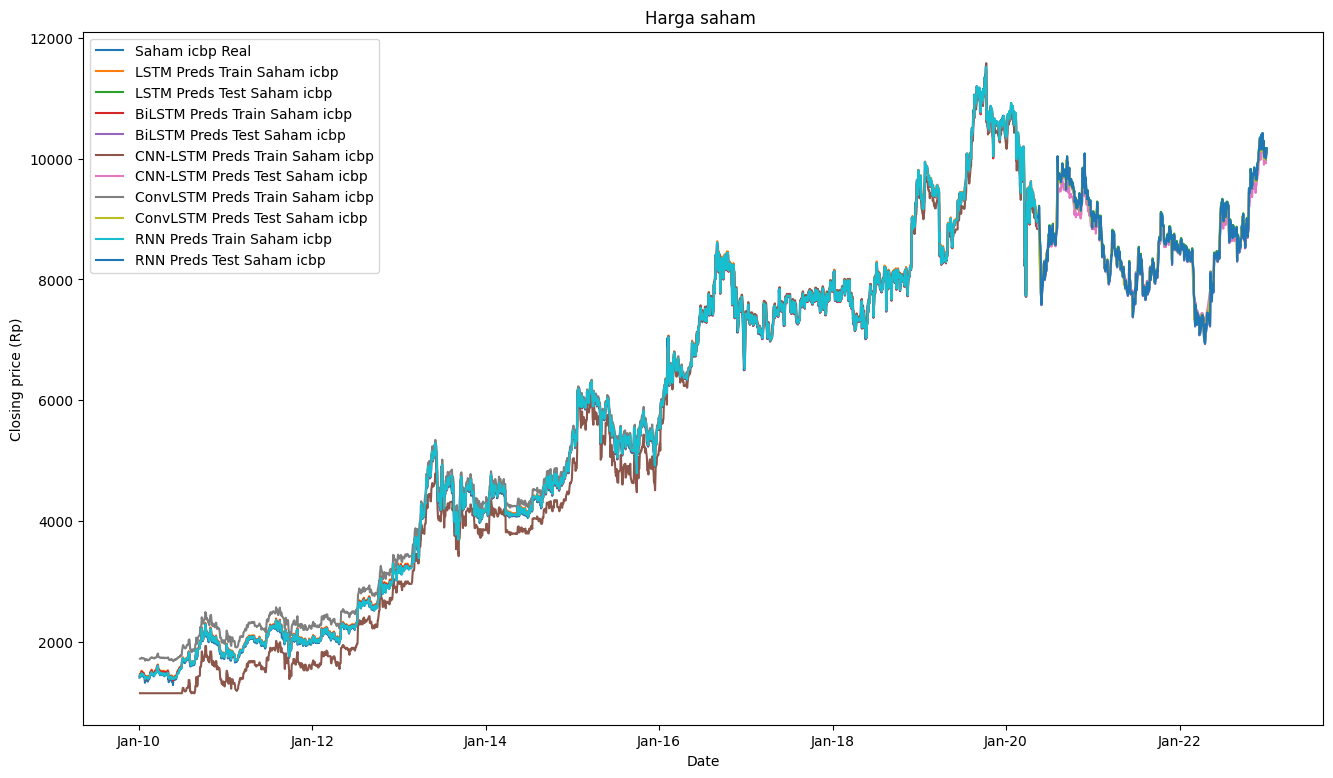

In [ ]:
# Plot everything by leveraging the very powerful matplotlib package
fig, ax = plt.subplots(figsize=(16,9))
name = 'icbp'
ax.plot(data_close.icbp.index, data_close.icbp, label='Saham {} Real'.format(name))
#VANILA LSTM
ax.plot(train_date_icbp, train_plot_icbp, label='LSTM Preds Train Saham {}'.format(name))
ax.plot(test_date_icbp, test_plot_icbp, label='LSTM Preds Test Saham {}'.format(name))
#BILSTM
ax.plot(train_date_icbp, train_plot_icbp_bilstm, label='BiLSTM Preds Train Saham {}'.format(name))
ax.plot(test_date_icbp, test_plot_icbp_bilstm, label='BiLSTM Preds Test Saham {}'.format(name))
#CNN-LSTM
ax.plot(train_date_icbp_cnnconv, train_plot_icbp_cnnlstm, label='CNN-LSTM Preds Train Saham {}'.format(name))
ax.plot(test_date_icbp_cnnconv, test_plot_icbp_cnnlstm, label='CNN-LSTM Preds Test Saham {}'.format(name))
#CONVLSTM
ax.plot(train_date_icbp_cnnconv, train_plot_icbp_conv, label='ConvLSTM Preds Train Saham {}'.format(name))
ax.plot(test_date_icbp_cnnconv, test_plot_icbp_conv, label='ConvLSTM Preds Test Saham {}'.format(name))
#RNN
ax.plot(train_date_icbp, train_plot_icbp_rnn, label='RNN Preds Train Saham {}'.format(name))
ax.plot(test_date_icbp, test_plot_icbp_rnn, label='RNN Preds Test Saham {}'.format(name))

# Define the date format
date_form = DateFormatter("%b-%y")
ax.xaxis.set_major_formatter(date_form)

ax.set_title('Harga saham ')
ax.set_xlabel('Date')
ax.set_ylabel('Closing price (Rp)')
ax.legend()

In [ ]:
icbpReal = pd.DataFrame()
icbpReal["LSTM"] = test_plot_icbp
icbpReal["BiLSTM"] = test_plot_icbp_bilstm 
icbpReal["CNN-LSTM"] = test_plot_icbp_cnnlstm 
icbpReal["ConvLSTM"] = test_plot_icbp_conv 
icbpReal["RNN"] = test_plot_icbp_rnn
icbpReal.head(10)

,LSTM,BiLSTM,CNN-LSTM,ConvLSTM,RNN
0,9060.677734,9021.714844,8869.504883,9006.056641,9044.598633
1,9037.806641,8998.812500,8869.504883,9022.619141,9021.483398
2,9060.677734,9021.714844,9006.632812,9163.647461,9044.598633
3,9220.675781,9181.974609,9006.632812,8949.119141,9206.403320
4,8946.283203,8907.179688,8780.168945,8412.267578,8929.022461
5,8350.037109,8310.762695,8313.992188,7854.177246,8328.029297
6,7774.670410,7736.063477,7783.198730,7759.157715,7750.153320
7,7774.670410,7736.063477,7783.198730,7629.333984,7750.153320
8,7613.237305,7574.950684,7914.267090,7843.826660,7588.346680
9,7912.929688,7874.092773,7935.846191,7913.277832,7888.843262


## JSMR

### VANILLA

In [48]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df_jsmr = pd.DataFrame(data_close.jsmr)
df_jsmr = pd.DataFrame(scaler.fit_transform(df_jsmr), columns = ['jsmr'])

In [49]:
#reset index
# df_jsmr = reset_index_data(df_jsmr)

jsmr_train_size, jsmr_test_size = data_size(df_jsmr)
train_jsmr = df_jsmr.iloc[:jsmr_train_size,:].values
test_jsmr = df_jsmr.iloc[jsmr_train_size:len(df_jsmr),:].values


#data to supervised
X_train_jsmr, y_train_jsmr = split_sequence(train_jsmr, 1)
X_test_jsmr, y_test_jsmr = split_sequence(test_jsmr, 1)
        
# X_train_jsmr, X_test_jsmr, y_train_jsmr, y_test_jsmr = train_test_split(jsmr_X, jsmr_y, test_size=0.33, random_state=42)

X_train_jsmr = reshape_data(X_train_jsmr,1)
X_test_jsmr = reshape_data(X_test_jsmr,1)


In [50]:
jsmrTestReal = pd.DataFrame(scaler.inverse_transform(test_jsmr))
jsmrTestReal.head(10)

,0
0,3517.003906
1,3656.488525
2,3686.378174
3,3686.378174
4,3925.494385
5,3895.604980
6,3795.973145
7,3536.930420
8,3805.936279
9,3925.494385


In [ ]:
# neuron, activation, n_steps, n_features,learning_rate, batch_size,epochs
cfg_jsmr = [8,'relu',1,1,0.01,16,200]
model_jsmr,history_jsmr_model,  = train_vanila_lstm(X_train_jsmr,y_train_jsmr,cfg_jsmr)

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_9 (LSTM)               (None, 8)                 320       
                                                                 
 dense_15 (Dense)            (None, 1)                 9         
                                                                 
Total params: 329
Trainable params: 329
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
129/129 [==============================] - 3s 10ms/step - loss: 0.1261 - mae: 0.1261 - val_loss: 0.0205 - val_mae: 0.0205
Epoch 2/200
129/129 [==============================] - 1s 5ms/step - loss: 0.0233 - mae: 0.0233 - val_loss: 0.0194 - val_mae: 0.0194
Epoch 3/200
129/129 [==============================] - 0s 4ms/step - loss: 0.0210 - mae: 0.0210 - val_loss: 0.0190 - val_mae: 0.0190
Epoch 4/200
129/129 [==============================

In [ ]:
preds_jsmr = model_jsmr.predict(X_test_jsmr)
matriks_evaluate(preds_jsmr,y_test_jsmr,'jsmr',4)

21/21 [==============================] - 0s 2ms/step
Matriks score for jsmr
mae score: 0.01106509490704047
r2 score 0.961304559032459
mape score 0.024794440906861313
rmse score 0.01494914956432721
round_up
mae score: 0.0111
r2 score 0.9613
mape score 0.0248
rmse score 0.0149


In [ ]:
preds_jsmr_train = model_jsmr.predict(X_train_jsmr)
matriks_evaluate(preds_jsmr_train,y_train_jsmr,'jsmr',4)

81/81 [==============================] - 0s 2ms/step
Matriks score for jsmr
mae score: 0.012214291155935652
r2 score 0.9941803466749768
mape score 0.03391933295196388
rmse score 0.01722060332962529
round_up
mae score: 0.0122
r2 score 0.9942
mape score 0.0339
rmse score 0.0172


### BILSTM

In [ ]:
# neuron, activation, n_steps, n_features,learning_rate, batch_size,epochs
cfg_jsmr = [8,'relu',1,1,0.01,16,200]
model_bidirectional_jsmr,history_jsmr_model_bidirectional,  = train_bidirectional_lstm(X_train_jsmr,y_train_jsmr,cfg_jsmr)

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_3 (Bidirectio  (None, 16)               640       
 nal)                                                            
                                                                 
 dense_16 (Dense)            (None, 1)                 17        
                                                                 
Total params: 657
Trainable params: 657
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
129/129 [==============================] - 5s 9ms/step - loss: 0.1051 - mae: 0.1051 - val_loss: 0.0218 - val_mae: 0.0218
Epoch 2/200
129/129 [==============================] - 0s 4ms/step - loss: 0.0223 - mae: 0.0223 - val_loss: 0.0212 - val_mae: 0.0212
Epoch 3/200
129/129 [==============================] - 1s 4ms/step - loss: 0.0193 - mae: 0.0193 - val_loss: 0.0173 - va

In [ ]:
preds_jsmr_bidirectional = model_bidirectional_jsmr.predict(X_test_jsmr)
matriks_evaluate(preds_jsmr_bidirectional,y_test_jsmr,'jsmr',4)

21/21 [==============================] - 1s 1ms/step
Matriks score for jsmr
mae score: 0.010934235170154889
r2 score 0.9615351286000962
mape score 0.024555695116722866
rmse score 0.014916611085301651
round_up
mae score: 0.0109
r2 score 0.9615
mape score 0.0246
rmse score 0.0149


In [ ]:
preds_jsmr_bidirectional_train = model_bidirectional_jsmr.predict(X_train_jsmr)
matriks_evaluate(preds_jsmr_bidirectional_train,y_train_jsmr,'jsmr',4)

81/81 [==============================] - 0s 2ms/step
Matriks score for jsmr
mae score: 0.01205588986864379
r2 score 0.9942376725723528
mape score 0.03138809894491486
rmse score 0.01718337839320354
round_up
mae score: 0.0121
r2 score 0.9942
mape score 0.0314
rmse score 0.0172


### CNN-LSTM

In [ ]:
df_jsmr_cnn = pd.DataFrame(data_close.jsmr)
df_jsmr_cnn = pd.DataFrame(scaler.fit_transform(df_jsmr_cnn), columns = ['jsmr'])

In [ ]:
jsmr_train_size_cnn, jsmr_test_size_cnn = data_size(df_jsmr_cnn)
train_cnn_jsmr = df_jsmr_cnn.iloc[:jsmr_train_size_cnn,:].values
test_cnn_jsmr = df_jsmr_cnn.iloc[jsmr_train_size_cnn:len(df_jsmr_cnn),:].values

#data to supervised
X_train_jsmr_cnn, y_train_jsmr_cnn = split_sequence(train_cnn_jsmr, 4)
X_test_jsmr_cnn, y_test_jsmr_cnn = split_sequence(test_cnn_jsmr, 4)
#split to train and test
# X_train_jsmr_cnn, X_test_jsmr_cnn, y_train_jsmr_cnn, y_test_jsmr_cnn = train_test_split(jsmr_X_cnn, jsmr_y_cnn, test_size=0.33, random_state=44)

X_train_jsmr_cnn = reshape_data_cnn(X_train_jsmr_cnn,1,2,2)
X_test_jsmr_cnn = reshape_data_cnn(X_test_jsmr_cnn,1,2,2)

In [ ]:
cfg_jsmr_cnn = [8,'relu',2,1,0.1,16,200]
model_cnn_jsmr,history_cnn_jsmr_model  = train_cnn_lstm(X_train_jsmr_cnn,y_train_jsmr_cnn,cfg_jsmr_cnn)

Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_27 (TimeDi  (None, None, 2, 64)      128       
 stributed)                                                      
                                                                 
 time_distributed_28 (TimeDi  (None, None, 1, 64)      0         
 stributed)                                                      
                                                                 
 time_distributed_29 (TimeDi  (None, None, 64)         0         
 stributed)                                                      
                                                                 
 lstm_17 (LSTM)              (None, 8)                 2336      
                                                                 
 dense_26 (Dense)            (None, 1)                 9         
                                                     

In [ ]:
preds_jsmr_cnn_lstm = model_cnn_jsmr.predict(X_test_jsmr_cnn)
matriks_evaluate(preds_jsmr_cnn_lstm,y_test_jsmr_cnn,'jsmr',4)

21/21 [==============================] - 1s 2ms/step
Matriks score for jsmr
mae score: 0.016526726575758946
r2 score 0.923816746691042
mape score 0.036556748863350454
rmse score 0.02044825318305346
round_up
mae score: 0.0165
r2 score 0.9238
mape score 0.0366
rmse score 0.0204


In [ ]:
preds_jsmr_cnn_lstm_train = model_cnn_jsmr.predict(X_train_jsmr_cnn)
matriks_evaluate(preds_jsmr_cnn_lstm_train,y_train_jsmr_cnn,'jsmr',4)

81/81 [==============================] - 0s 4ms/step
Matriks score for jsmr
mae score: 0.018587876048489348
r2 score 0.9858131229970891
mape score 0.05849188798547573
rmse score 0.02512864886314187
round_up
mae score: 0.0186
r2 score 0.9858
mape score 0.0585
rmse score 0.0251


### CONVLSMT

In [ ]:
df_jsmr_conv = pd.DataFrame(data_close.jsmr)
df_jsmr_conv = pd.DataFrame(scaler.fit_transform(df_jsmr_conv), columns = ['jsmr'])

In [ ]:
jsmr_train_size_conv, jsmr_test_size_conv = data_size(df_jsmr_conv)
train_conv_jsmr = df_jsmr_conv.iloc[:jsmr_train_size_conv,:].values
test_conv_jsmr = df_jsmr_conv.iloc[jsmr_train_size_conv:len(df_jsmr_conv),:].values

#data to supervised
X_train_jsmr_conv, y_train_jsmr_conv = split_sequence(train_conv_jsmr, 4)
X_test_jsmr_conv, y_test_jsmr_conv = split_sequence(test_conv_jsmr, 4)

X_train_jsmr_conv = reshape_data_conv(X_train_jsmr_conv,1,1,1,4)
X_test_jsmr_conv = reshape_data_conv(X_test_jsmr_conv,1,1,1,4)

In [ ]:
cfg_jsmr_conv = [8,'relu',4,1,1,0.1,16,200]
model_conv_jsmr,history_conv_jsmr_model  = train_conv_lstm(X_train_jsmr_conv,y_train_jsmr_conv,cfg_jsmr_conv)

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d_4 (ConvLSTM2D)  (None, 1, 3, 8)           608       
                                                                 
 flatten_9 (Flatten)         (None, 24)                0         
                                                                 
 dense_21 (Dense)            (None, 1)                 25        
                                                                 
Total params: 633
Trainable params: 633
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
129/129 [==============================] - 9s 13ms/step - loss: 0.0959 - mae: 0.0959 - val_loss: 0.0568 - val_mae: 0.0568
Epoch 2/200
129/129 [==============================] - 1s 7ms/step - loss: 0.0797 - mae: 0.0797 - val_loss: 0.1399 - val_mae: 0.1399
Epoch 3/200
129/129 [==============================]

In [ ]:
preds_jsmr_conv_lstm = model_conv_jsmr.predict(X_test_jsmr_conv)
matriks_evaluate(preds_jsmr_conv_lstm,y_test_jsmr_conv,'jsmr',4)

21/21 [==============================] - 1s 3ms/step
Matriks score for jsmr
mae score: 0.011236644928771947
r2 score 0.9588349982971699
mape score 0.025359968302628783
rmse score 0.015385688110460047
round_up
mae score: 0.0112
r2 score 0.9588
mape score 0.0254
rmse score 0.0154


In [ ]:
preds_jsmr_conv_lstm_train = model_conv_jsmr.predict(X_train_jsmr_conv)
matriks_evaluate(preds_jsmr_conv_lstm_train,y_train_jsmr_conv,'jsmr',4)

81/81 [==============================] - 0s 4ms/step
Matriks score for jsmr
mae score: 0.012680816408071538
r2 score 0.993738082216684
mape score 0.0386767037357854
rmse score 0.017748048308614903
round_up
mae score: 0.0127
r2 score 0.9937
mape score 0.0387
rmse score 0.0177


### RNN

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df_jsmr_rnn = pd.DataFrame(data_close.jsmr)
df_jsmr_rnn = pd.DataFrame(scaler.fit_transform(df_jsmr_rnn), columns = ['jsmr'])

In [ ]:
jsmr_rnn_train_size, jsmr_rnn_test_size = data_size(df_jsmr_rnn)
train_rnn = df_jsmr_rnn.iloc[:jsmr_rnn_train_size,:].values
test_rnn = df_jsmr_rnn.iloc[jsmr_rnn_train_size:len(df_jsmr_rnn),:].values

#data to supervised
X_train_jsmr_rnn, y_train_jsmr_rnn = split_sequence(train_rnn, 1)
X_test_jsmr_rnn, y_test_jsmr_rnn = split_sequence(test_rnn, 1)

X_train_jsmr_rnn = reshape_data(X_train_jsmr_rnn,1)
X_test_jsmr_rnn = reshape_data(X_test_jsmr_rnn,1)


In [ ]:
cfg_jsmr_rnn = [8,'relu',1,1,0.01,16,200]
model_jsmr_rnn,history_jsmr_model_rnn  = train_model_rnn(X_train_jsmr_rnn,y_train_jsmr_rnn,cfg_jsmr_rnn)

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_3 (SimpleRNN)    (None, 8)                 80        
                                                                 
 dense_19 (Dense)            (None, 1)                 9         
                                                                 
Total params: 89
Trainable params: 89
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
129/129 [==============================] - 1s 4ms/step - loss: 0.1739 - mae: 0.1739 - val_loss: 0.0264 - val_mae: 0.0264
Epoch 2/200
129/129 [==============================] - 0s 2ms/step - loss: 0.0153 - mae: 0.0153 - val_loss: 0.0158 - val_mae: 0.0158
Epoch 3/200
129/129 [==============================] - 0s 2ms/step - loss: 0.0120 - mae: 0.0120 - val_loss: 0.0169 - val_mae: 0.0169
Epoch 4/200
129/129 [==============================] -

In [ ]:
preds_jsmr_rnn = model_jsmr_rnn.predict(X_test_jsmr_rnn)
matriks_evaluate(preds_jsmr_rnn,y_test_jsmr_rnn,'jsmr',4)

21/21 [==============================] - 0s 1ms/step
Matriks score for jsmr
mae score: 0.01098122933649841
r2 score 0.9614928793660719
mape score 0.02486114843819733
rmse score 0.014996688883074738
round_up
mae score: 0.011
r2 score 0.9615
mape score 0.0249
rmse score 0.015


In [ ]:
preds_jsmr_rnn_train = model_jsmr_rnn.predict(X_train_jsmr_rnn)
matriks_evaluate(preds_jsmr_rnn_train,y_train_jsmr_rnn,'jsmr',4)

81/81 [==============================] - 0s 1ms/step
Matriks score for jsmr
mae score: 0.011850438807537849
r2 score 0.9943696996094256
mape score 0.03179819926690193
rmse score 0.017033032996892197
round_up
mae score: 0.0119
r2 score 0.9944
mape score 0.0318
rmse score 0.017


### PLOT DATA SAHAM JSMR

In [ ]:
date = pd.DataFrame(data_close.jsmr.index)
train_date_jsmr = pd.DataFrame(date.iloc[1:jsmr_train_size,:].values)
test_date_jsmr = pd.DataFrame(date.iloc[jsmr_train_size:len(df_jsmr)-1,:].values)
train_date_jsmr_cnnconv = pd.DataFrame(date.iloc[4:jsmr_train_size,:].values)
test_date_jsmr_cnnconv = pd.DataFrame(date.iloc[jsmr_train_size:len(df_jsmr)-4,:].values)
#VANILA
train_plot_jsmr = pd.DataFrame(scaler.inverse_transform(preds_jsmr_train), columns=['jsmr'])
test_plot_jsmr = pd.DataFrame(scaler.inverse_transform(preds_jsmr), columns=['jsmr'])
#BILSTM
train_plot_jsmr_bilstm = pd.DataFrame(scaler.inverse_transform(preds_jsmr_bidirectional_train), columns=['jsmr'])
test_plot_jsmr_bilstm = pd.DataFrame(scaler.inverse_transform(preds_jsmr_bidirectional), columns=['jsmr'])
#CNN-LSTM
train_plot_jsmr_cnnlstm = pd.DataFrame(scaler.inverse_transform(preds_jsmr_cnn_lstm_train), columns=['jsmr'])
test_plot_jsmr_cnnlstm = pd.DataFrame(scaler.inverse_transform(preds_jsmr_cnn_lstm), columns=['jsmr'])
#CONV-LSTM
train_plot_jsmr_conv = pd.DataFrame(scaler.inverse_transform(preds_jsmr_conv_lstm_train), columns=['jsmr'])
test_plot_jsmr_conv = pd.DataFrame(scaler.inverse_transform(preds_jsmr_conv_lstm), columns=['jsmr'])
#RNN
train_plot_jsmr_rnn = pd.DataFrame(scaler.inverse_transform(preds_jsmr_rnn_train), columns=['jsmr'])
test_plot_jsmr_rnn = pd.DataFrame(scaler.inverse_transform(preds_jsmr_rnn), columns=['jsmr'])


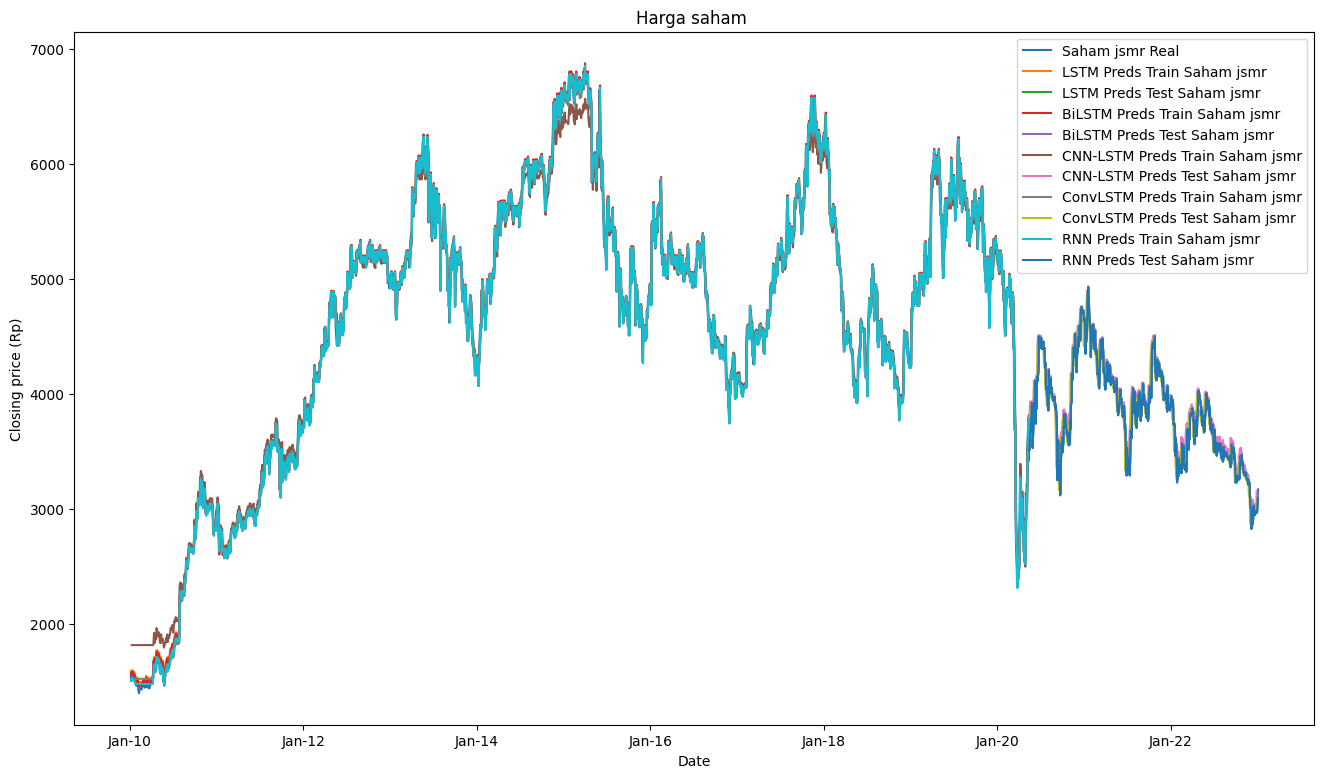

In [ ]:
# Plot everything by leveraging the very powerful matplotlib package
fig, ax = plt.subplots(figsize=(16,9))
name = 'jsmr'
ax.plot(data_close.jsmr.index, data_close.jsmr, label='Saham {} Real'.format(name))
#VANILA LSTM
ax.plot(train_date_jsmr, train_plot_jsmr, label='LSTM Preds Train Saham {}'.format(name))
ax.plot(test_date_jsmr, test_plot_jsmr, label='LSTM Preds Test Saham {}'.format(name))
#BILSTM
ax.plot(train_date_jsmr, train_plot_jsmr_bilstm, label='BiLSTM Preds Train Saham {}'.format(name))
ax.plot(test_date_jsmr, test_plot_jsmr_bilstm, label='BiLSTM Preds Test Saham {}'.format(name))
#CNN-LSTM
ax.plot(train_date_jsmr_cnnconv, train_plot_jsmr_cnnlstm, label='CNN-LSTM Preds Train Saham {}'.format(name))
ax.plot(test_date_jsmr_cnnconv, test_plot_jsmr_cnnlstm, label='CNN-LSTM Preds Test Saham {}'.format(name))
#CONVLSTM
ax.plot(train_date_jsmr_cnnconv, train_plot_jsmr_conv, label='ConvLSTM Preds Train Saham {}'.format(name))
ax.plot(test_date_jsmr_cnnconv, test_plot_jsmr_conv, label='ConvLSTM Preds Test Saham {}'.format(name))
#RNN
ax.plot(train_date_jsmr, train_plot_jsmr_rnn, label='RNN Preds Train Saham {}'.format(name))
ax.plot(test_date_jsmr, test_plot_jsmr_rnn, label='RNN Preds Test Saham {}'.format(name))

# Define the date format
date_form = DateFormatter("%b-%y")
ax.xaxis.set_major_formatter(date_form)

ax.set_title('Harga saham ')
ax.set_xlabel('Date')
ax.set_ylabel('Closing price (Rp)')
ax.legend()

In [180]:
jsmrReal = pd.DataFrame()
jsmrReal["LSTM"] = test_plot_jsmr
jsmrReal["BiLSTM"] = test_plot_jsmr_bilstm 
jsmrReal["CNN-LSTM"] = test_plot_jsmr_cnnlstm 
jsmrReal["ConvLSTM"] = test_plot_jsmr_conv 
jsmrReal["RNN"] = test_plot_jsmr_rnn
jsmrReal.head(10)

,LSTM,BiLSTM,CNN-LSTM,ConvLSTM,RNN
0,3521.190430,3516.604980,3725.425049,3652.998047,3507.436279
1,3521.190430,3516.604980,3730.381592,3675.175049,3507.436279
2,3660.698730,3656.232178,3933.768066,3859.388428,3648.097168
3,3690.625977,3686.180908,3933.768066,3863.895020,3678.239014
4,3690.625977,3686.180908,3927.538086,3820.705811,3678.239014
5,3930.418945,3926.116943,3843.564697,3627.328613,3919.371338
6,3900.410400,3896.092529,3849.790527,3776.165039,3889.229980
7,3800.450684,3796.076660,3940.183105,3857.406982,3788.758301
8,3541.104248,3536.538086,3941.049072,3845.778809,3527.530762
9,3810.441406,3806.073730,3911.098633,3878.544189,3798.805420


## PLOT DATA SAHAM BERDASARKAN MODEL

## PLOT MODEL TERBAIK BERDASARKAN SAHAM

In [120]:
# # Plot everything by leveraging the very powerful matplotlib package
# fig, ax = plt.subplots(figsize=(16,9))

# #ANTM
# #VANILA
# ax.plot(data_close.antm.index, data_close.antm, label='Saham {} Real'.format('antm'))
# ax.plot(train_date_antm, train_plot_antm, label='LSTM Preds Train Saham {}'.format('antm'))
# ax.plot(test_date_antm, test_plot_antm, label='LSTM Preds Test Saham {}'.format('antm'))

# # Define the date format
# date_form = DateFormatter("%b-%y")
# ax.xaxis.set_major_formatter(date_form)

# ax.set_title('Harga saham ')
# ax.set_xlabel('Date')
# ax.set_ylabel('Closing price (Rp)')
# ax.legend()

In [121]:
# # Plot everything by leveraging the very powerful matplotlib package
# fig, ax = plt.subplots(figsize=(16,9))

# #ANTM
# ax.plot(data_close.antm.index, data_close.antm, label='Saham {} Real'.format(name))
# #VANILA LSTM
# ax.plot(train_date_antm, train_plot_antm, label='LSTM Preds Train Saham {}'.format(name))
# ax.plot(test_date_antm, test_plot_antm, label='LSTM Preds Test Saham {}'.format(name))
# #BILSTM
# ax.plot(train_date_antm, train_plot_antm_bilstm, label='BiLSTM Preds Train Saham {}'.format(name))
# ax.plot(test_date_antm, test_plot_antm_bilstm, label='BiLSTM Preds Test Saham {}'.format(name))
# #CNN-LSTM
# ax.plot(train_date_antm, train_plot_antm_cnnlstm, label='CNN-LSTM Preds Train Saham {}'.format(name))
# ax.plot(test_date_antm, test_plot_antm_cnnlstm, label='CNN-LSTM Preds Test Saham {}'.format(name))
# #CONVLSTM
# ax.plot(train_date_antm, train_plot_antm_conv, label='ConvLSTM Preds Train Saham {}'.format(name))
# ax.plot(test_date_antm, test_plot_antm_conv, label='ConvLSTM Preds Test Saham {}'.format(name))
# #RNN
# ax.plot(train_date_antm, train_plot_antm_rnn, label='RNN Preds Train Saham {}'.format(name))
# ax.plot(test_date_antm, test_plot_antm_rnn, label='RNN Preds Test Saham {}'.format(name))

# #ASII
# ax.plot(data_close.asii.index, data_close.asii, label='Saham {} Real'.format(name))
# #VANILA LSTM
# ax.plot(train_date_asii, train_plot_asii, label='LSTM Preds Train Saham {}'.format(name))
# ax.plot(test_date_asii, test_plot_asii, label='LSTM Preds Test Saham {}'.format(name))
# #BILSTM
# ax.plot(train_date_asii, train_plot_asii_bilstm, label='BiLSTM Preds Train Saham {}'.format(name))
# ax.plot(test_date_asii, test_plot_asii_bilstm, label='BiLSTM Preds Test Saham {}'.format(name))
# #CNN-LSTM
# ax.plot(train_date_asii, train_plot_asii_cnnlstm, label='CNN-LSTM Preds Train Saham {}'.format(name))
# ax.plot(test_date_asii, test_plot_asii_cnnlstm, label='CNN-LSTM Preds Test Saham {}'.format(name))
# #CONVLSTM
# ax.plot(train_date_asii, train_plot_asii_conv, label='ConvLSTM Preds Train Saham {}'.format(name))
# ax.plot(test_date_asii, test_plot_asii_conv, label='ConvLSTM Preds Test Saham {}'.format(name))
# #RNN
# ax.plot(train_date_asii, train_plot_asii_rnn, label='RNN Preds Train Saham {}'.format(name))
# ax.plot(test_date_asii, test_plot_asii_rnn, label='RNN Preds Test Saham {}'.format(name))

# #ICBP
# #VANILA LSTM
# ax.plot(train_date_icbp, train_plot_icbp, label='LSTM Preds Train Saham {}'.format(name))
# ax.plot(test_date_icbp, test_plot_icbp, label='LSTM Preds Test Saham {}'.format(name))
# #BILSTM
# ax.plot(train_date_icbp, train_plot_icbp_bilstm, label='BiLSTM Preds Train Saham {}'.format(name))
# ax.plot(test_date_icbp, test_plot_icbp_bilstm, label='BiLSTM Preds Test Saham {}'.format(name))
# #CNN-LSTM
# ax.plot(train_date_icbp_cnnconv, train_plot_icbp_cnnlstm, label='CNN-LSTM Preds Train Saham {}'.format(name))
# ax.plot(test_date_icbp_cnnconv, test_plot_icbp_cnnlstm, label='CNN-LSTM Preds Test Saham {}'.format(name))
# #CONVLSTM
# ax.plot(train_date_icbp_cnnconv, train_plot_icbp_conv, label='ConvLSTM Preds Train Saham {}'.format(name))
# ax.plot(test_date_icbp_cnnconv, test_plot_icbp_conv, label='ConvLSTM Preds Test Saham {}'.format(name))

# #RNN
# ax.plot(train_date_icbp, train_plot_icbp_rnn, label='RNN Preds Train Saham {}'.format(name))
# ax.plot(test_date_icbp, test_plot_icbp_rnn, label='RNN Preds Test Saham {}'.format(name))
# #JSMR
# ax.plot(train_date_jsmr, train_plot_jsmr, label='LSTM Preds Train Saham {}'.format(name))
# ax.plot(test_date_jsmr, test_plot_jsmr, label='LSTM Preds Test Saham {}'.format(name))
# #BILSTM
# ax.plot(train_date_jsmr, train_plot_jsmr_bilstm, label='BiLSTM Preds Train Saham {}'.format(name))
# ax.plot(test_date_jsmr, test_plot_jsmr_bilstm, label='BiLSTM Preds Test Saham {}'.format(name))
# #CNN-LSTM
# ax.plot(train_date_jsmr_cnnconv, train_plot_jsmr_cnnlstm, label='CNN-LSTM Preds Train Saham {}'.format(name))
# ax.plot(test_date_jsmr_cnnconv, test_plot_jsmr_cnnlstm, label='CNN-LSTM Preds Test Saham {}'.format(name))
# #CONVLSTM
# ax.plot(train_date_jsmr_cnnconv, train_plot_jsmr_conv, label='ConvLSTM Preds Train Saham {}'.format(name))
# ax.plot(test_date_jsmr_cnnconv, test_plot_jsmr_conv, label='ConvLSTM Preds Test Saham {}'.format(name))
# #RNN
# ax.plot(train_date_jsmr, train_plot_jsmr_rnn, label='RNN Preds Train Saham {}'.format(name))
# ax.plot(test_date_jsmr, test_plot_jsmr_rnn, label='RNN Preds Test Saham {}'.format(name))


# # Define the date format
# date_form = DateFormatter("%b-%y")
# ax.xaxis.set_major_formatter(date_form)

# ax.set_title('Harga saham ')
# ax.set_xlabel('Date')
# ax.set_ylabel('Closing price (Rp)')
# ax.legend()

# APAKAH UKURAN DATA BERPENGARUH DALAM PEMODELAN DATA SAHAM?

In [2]:
yf.pdr_override()

stock = 'ICBP.JK'
today = date.today()
# print(today)
start_date = '2016-01-01'
# end_date = '2022-08-02'

icbp_data = pdr.get_data_yahoo(stock,start=start_date, end=today)
icbp_data.head(5)


[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2016-01-04,6575.0,6750.0,6575.0,6600.0,5590.148926,5158400
2016-01-05,6600.0,6700.0,6425.0,6500.0,5505.449707,5101400
2016-01-06,6500.0,6962.5,6500.0,6937.5,5876.008789,5499600
2016-01-07,6875.0,6975.0,6837.5,6937.5,5876.008789,7831200
2016-01-08,6900.0,7037.5,6887.5,7037.5,5960.708008,4277800


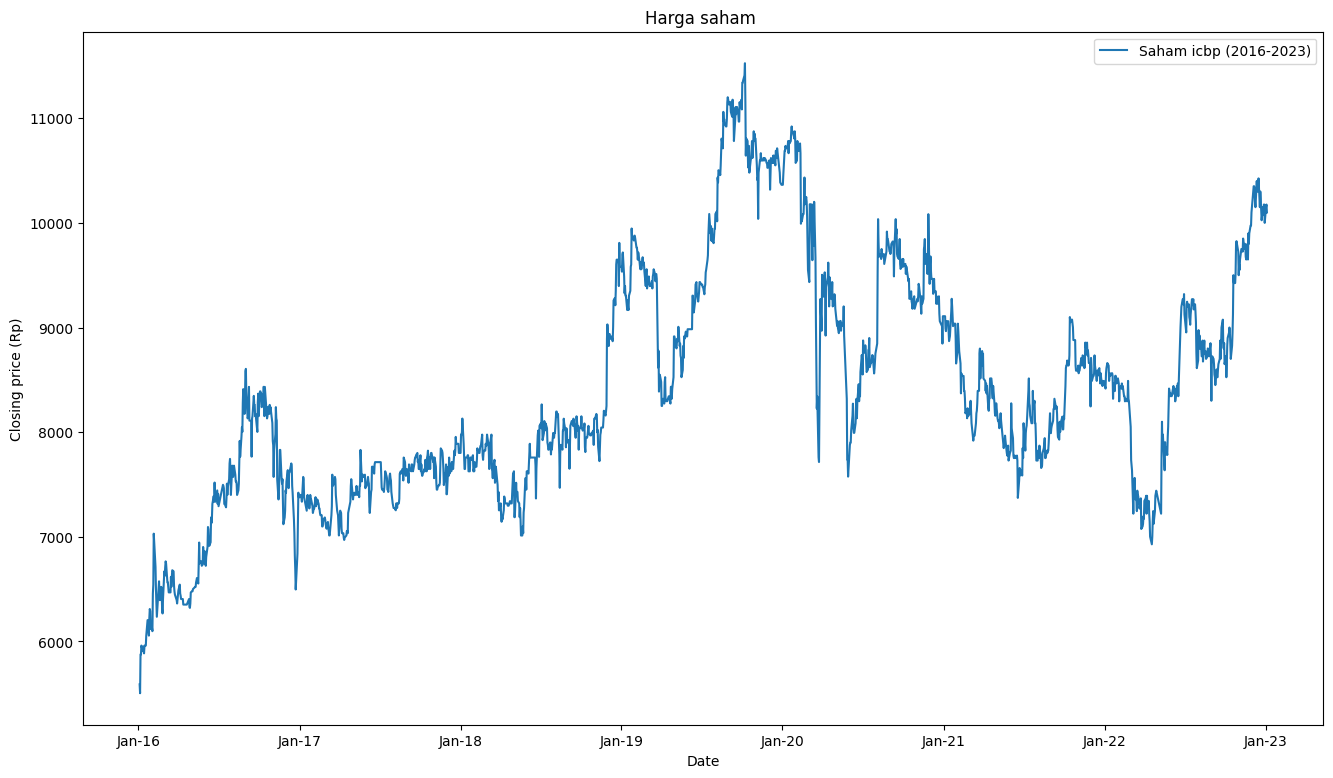

In [4]:
# Plot everything by leveraging the very powerful matplotlib package
fig, ax = plt.subplots(figsize=(16,9))

ax.plot(icbp_data.index, icbp_data['Adj Close'], label='Saham {} (2016-2023)'.format('icbp'))
# ax.plot(data_close['icbp'].index, data_close['icbp'], label='Saham {} (2010-now)'.format('icbp'))


# Define the date format
date_form = DateFormatter("%b-%y")
ax.xaxis.set_major_formatter(date_form)

ax.set_title('Harga saham ')
ax.set_xlabel('Date')
ax.set_ylabel('Closing price (Rp)')
ax.legend()

## VANILLA

In [198]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df_icbp_2 = pd.DataFrame(icbp_data["Adj Close"])
df_icbp_2 = pd.DataFrame(scaler.fit_transform(df_icbp_2), columns = ['icbp'])
df_icbp_2

,icbp
0,0.014070
1,0.000000
2,0.061554
3,0.061554
4,0.075624
...,...
1750,0.775667
1751,0.775667
1752,0.746598
1753,0.771515


In [199]:
icbp_train_size_2, icbp_test_size = data_size(df_icbp_2)
train_icbp_2 = df_icbp_2.iloc[:icbp_train_size_2,:].values
test_icbp_2 = df_icbp_2.iloc[icbp_train_size_2:len(df_icbp),:].values


#data to supervised
X_train_icbp_2, y_train_icbp_2 = split_sequence(train_icbp_2, 1)
X_test_icbp_2, y_test_icbp_2 = split_sequence(test_icbp_2, 1)
        
# X_train_icbp_2, X_test_icbp_2, y_train_icbp_2, y_test_icbp_2 = train_test_split(icbp_X, icbp_y, test_size=0.33, random_state=42)

X_train_icbp_2 = reshape_data(X_train_icbp_2,1)
X_test_icbp_2 = reshape_data(X_test_icbp_2,1)


In [205]:
# neuron, activation, n_steps, n_features,learning_rate, batch_size,epochs
cfg_icbp_2 = [8,'relu',1,1,0.01,16,200]
model_icbp_2,history_icbp_model_2  = train_vanila_lstm(X_train_icbp_2,y_train_icbp_2,cfg_icbp_2)

Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_21 (LSTM)              (None, 8)                 320       
                                                                 
 dense_30 (Dense)            (None, 1)                 9         
                                                                 
Total params: 329
Trainable params: 329
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
71/71 [==============================] - 8s 8ms/step - loss: 0.1700 - mae: 0.1700 - val_loss: 0.0741 - val_mae: 0.0741
Epoch 2/200
71/71 [==============================] - 0s 4ms/step - loss: 0.0372 - mae: 0.0372 - val_loss: 0.0183 - val_mae: 0.0183
Epoch 3/200
71/71 [==============================] - 0s 3ms/step - loss: 0.0246 - mae: 0.0246 - val_loss: 0.0214 - val_mae: 0.0214
Epoch 4/200
71/71 [==============================] - 0s 3m

In [206]:
preds_icbp_2 = model_icbp_2.predict(X_test_icbp_2)
matriks_evaluate(preds_icbp_2,y_test_icbp_2,'icbp',4)

11/11 [==============================] - 0s 2ms/step
Matriks score for icbp
mae score: 0.01758944834960699
r2 score 0.9670938941373118
mape score 0.03644919917818343
rmse score 0.023640577762300906
round_up
mae score: 0.0176
r2 score 0.9671
mape score 0.0364
rmse score 0.0236


In [207]:
preds_icbp_train_2 = model_icbp_2.predict(X_train_icbp_2)
matriks_evaluate(preds_icbp_train_2,y_train_icbp_2,'icbp',4)

44/44 [==============================] - 0s 3ms/step
Matriks score for icbp
mae score: 0.023315947413536264
r2 score 0.9736050431548433
mape score 0.059005135499030296
rmse score 0.03262178842950667
round_up
mae score: 0.0233
r2 score 0.9736
mape score 0.059
rmse score 0.0326


## BiLSTM

In [208]:
# neuron, activation, n_steps, n_features,learning_rate, batch_size,epochs
cfg_icbp_bilstm_2 = [8,'relu',1,1,0.01,16,200]
model_bidirectional_icbp_2,history_icbp_model_bidirectional_2  = train_bidirectional_lstm(X_train_icbp,y_train_icbp,cfg_icbp_bilstm_2)

Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_5 (Bidirectio  (None, 16)               640       
 nal)                                                            
                                                                 
 dense_31 (Dense)            (None, 1)                 17        
                                                                 
Total params: 657
Trainable params: 657
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
129/129 [==============================] - 4s 7ms/step - loss: 0.0466 - mae: 0.0466 - val_loss: 0.0508 - val_mae: 0.0508
Epoch 2/200
129/129 [==============================] - 0s 3ms/step - loss: 0.0083 - mae: 0.0083 - val_loss: 0.0174 - val_mae: 0.0174
Epoch 3/200
129/129 [==============================] - 1s 4ms/step - loss: 0.0081 - mae: 0.0081 - val_loss: 0.0182 - va

In [209]:
preds_icbp_bidirectional_2 = model_bidirectional_icbp_2.predict(X_test_icbp_2)
matriks_evaluate(preds_icbp_bidirectional_2,y_test_icbp_2,'icbp',4)

11/11 [==============================] - 1s 2ms/step
Matriks score for icbp
mae score: 0.016378291520381384
r2 score 0.9701341208035524
mape score 0.03523921477336564
rmse score 0.022198575669083176
round_up
mae score: 0.0164
r2 score 0.9701
mape score 0.0352
rmse score 0.0222


In [210]:
preds_icbp_bidirectional_train_2 = model_bidirectional_icbp_2.predict(X_train_icbp_2)
matriks_evaluate(preds_icbp_bidirectional_train_2,y_train_icbp_2,'icbp',4)

44/44 [==============================] - 0s 3ms/step
Matriks score for icbp
mae score: 0.016266810392310774
r2 score 0.9852121245356326
mape score 0.04729988915488986
rmse score 0.024218248720830532
round_up
mae score: 0.0163
r2 score 0.9852
mape score 0.0473
rmse score 0.0242


## CNN-LSTM

In [ ]:
# df_icbp_2 = pd.DataFrame(icbp_data["Adj Close"])
# df_icbp_2 = pd.DataFrame(scaler.fit_transform(df_icbp_2), columns = ['icbp'])
# df_icbp_2

In [215]:
icbp_train_size_cnn_2, icbp_test_size_cnn_2 = data_size(df_icbp_2)
train_cnn_2_icbp = df_icbp_2.iloc[:icbp_train_size_2,:].values
test_cnn_2_icbp = df_icbp_2.iloc[icbp_train_size_2:len(df_icbp_2),:].values

#data to supervised
X_train_icbp_cnn_2, y_train_icbp_cnn_2 = split_sequence(train_cnn_2_icbp, 2)
X_test_icbp_cnn_2, y_test_icbp_cnn_2 = split_sequence(test_cnn_2_icbp, 2)
#split to train and test
# X_train_icbp_cnn_2, X_test_icbp_cnn_2, y_train_icbp_cnn_2, y_test_icbp_cnn_2 = train_test_split(icbp_X_cnn_2, icbp_y_cnn_2, test_size=0.33, random_state=44)

X_train_icbp_cnn_2 = reshape_data_cnn(X_train_icbp_cnn_2,1,1,2)
X_test_icbp_cnn_2 = reshape_data_cnn(X_test_icbp_cnn_2,1,1,2)

In [216]:
cfg_icbp_cnn_2 = [8,'relu',2,1,0.1,16,200]
model_cnn_icbp_2 ,history_cnn_icbp_model_2  = train_cnn_lstm(X_train_icbp_cnn_2,y_train_icbp_cnn_2,cfg_icbp_cnn_2)

Model: "sequential_33"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_36 (TimeDi  (None, None, 2, 64)      128       
 stributed)                                                      
                                                                 
 time_distributed_37 (TimeDi  (None, None, 1, 64)      0         
 stributed)                                                      
                                                                 
 time_distributed_38 (TimeDi  (None, None, 64)         0         
 stributed)                                                      
                                                                 
 lstm_24 (LSTM)              (None, 8)                 2336      
                                                                 
 dense_33 (Dense)            (None, 1)                 9         
                                                     

In [217]:
preds_icbp_cnn_lstm_2 = model_cnn_icbp_2.predict(X_test_icbp_cnn_2)
matriks_evaluate(preds_icbp_cnn_lstm_2,y_test_icbp_cnn_2,'icbp',4)

11/11 [==============================] - 0s 2ms/step
Matriks score for icbp
mae score: 0.017530585261558037
r2 score 0.9664701279491628
mape score 0.037728012690722325
rmse score 0.023358537401332972
round_up
mae score: 0.0175
r2 score 0.9665
mape score 0.0377
rmse score 0.0234


In [218]:
preds_icbp_cnn_lstm_train_2 = model_cnn_icbp_2.predict(X_train_icbp_cnn_2)
matriks_evaluate(preds_icbp_cnn_lstm_train_2,y_train_icbp_cnn_2,'icbp',4)

44/44 [==============================] - 0s 2ms/step
Matriks score for icbp
mae score: 0.020211018122378095
r2 score 0.9792608774784731
mape score 0.06961820886952583
rmse score 0.029173363951345097
round_up
mae score: 0.0202
r2 score 0.9793
mape score 0.0696
rmse score 0.0292


## CONV-LSTM

In [220]:
icbp_train_size_conv_2, icbp_test_size_conv_2 = data_size(df_icbp_2)
train_conv_2_icbp = df_icbp_2.iloc[:icbp_train_size_2,:].values
test_conv_2_icbp = df_icbp_2.iloc[icbp_train_size_2:len(df_icbp_2),:].values

#data to supervised
X_train_icbp_conv_2, y_train_icbp_conv_2 = split_sequence(train_conv_2_icbp, 2)
X_test_icbp_conv_2, y_test_icbp_conv_2 = split_sequence(test_conv_2_icbp, 2)
#split to train and test
# X_train_icbp_conv_2, X_test_icbp_conv_2, y_train_icbp_conv_2, y_test_icbp_conv_2 = train_test_split(icbp_X_conv_2, icbp_y_conv_2, test_size=0.33, random_state=44)

X_train_icbp_conv_2 = reshape_data_conv(X_train_icbp_conv_2,1,1,1,2)
X_test_icbp_conv_2 = reshape_data_conv(X_test_icbp_conv_2,1,1,1,2)

In [221]:
cfg_icbp_conv_2 = [8,'relu',2,1,1,0.1,16,200]
model_conv_icbp_2,history_conv_icbp_model_2  = train_conv_lstm(X_train_icbp_conv_2,y_train_icbp_conv_2,cfg_icbp_conv_2)

Model: "sequential_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d_5 (ConvLSTM2D)  (None, 1, 1, 8)           608       
                                                                 
 flatten_18 (Flatten)        (None, 8)                 0         
                                                                 
 dense_34 (Dense)            (None, 1)                 9         
                                                                 
Total params: 617
Trainable params: 617
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
71/71 [==============================] - 5s 12ms/step - loss: 0.1025 - mae: 0.1025 - val_loss: 0.0587 - val_mae: 0.0587
Epoch 2/200
71/71 [==============================] - 0s 5ms/step - loss: 0.0303 - mae: 0.0303 - val_loss: 0.0411 - val_mae: 0.0411
Epoch 3/200
71/71 [==============================] - 0s 

In [222]:
preds_icbp_conv_lstm_2 = model_conv_icbp_2.predict(X_test_icbp_conv_2)
matriks_evaluate(preds_icbp_conv_lstm_2,y_test_icbp_conv_2,'icbp',4)

11/11 [==============================] - 0s 3ms/step
Matriks score for icbp
mae score: 0.01619989548204373
r2 score 0.9714028165351734
mape score 0.033778426532339915
rmse score 0.021962876004191664
round_up
mae score: 0.0162
r2 score 0.9714
mape score 0.0338
rmse score 0.022


In [223]:
preds_icbp_conv_lstm_train_2 = model_conv_icbp_2.predict(X_train_icbp_conv_2)
matriks_evaluate(preds_icbp_conv_lstm_train_2,y_train_icbp_conv_2,'icbp',4)

44/44 [==============================] - 0s 2ms/step
Matriks score for icbp
mae score: 0.01738457144233645
r2 score 0.9838015048934972
mape score 0.04344870439196458
rmse score 0.02548680178291841
round_up
mae score: 0.0174
r2 score 0.9838
mape score 0.0434
rmse score 0.0255


## RNN

In [224]:
icbp_rnn_train_size_2, icbp_rnn_test_size_2 = data_size(df_icbp_2)
train_rnn_2 = df_icbp_2.iloc[:icbp_rnn_train_size_2,:].values
test_rnn_2 = df_icbp_2.iloc[icbp_rnn_train_size_2:len(df_icbp_2),:].values

#data to supervised
X_train_icbp_rnn_2, y_train_icbp_rnn_2 = split_sequence(train_rnn_2, 1)
X_test_icbp_rnn_2, y_test_icbp_rnn_2 = split_sequence(test_rnn_2, 1)

X_train_icbp_rnn_2 = reshape_data(X_train_icbp_rnn_2,1)
X_test_icbp_rnn_2 = reshape_data(X_test_icbp_rnn_2,1)


In [225]:
cfg_icbp_rnn_2 = [8,'relu',1,1,0.01,16,200]
model_icbp_rnn_2,history_icbp_model_rnn_2  = train_model_rnn(X_train_icbp_rnn_2,y_train_icbp_rnn_2,cfg_icbp_rnn_2)

Model: "sequential_35"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_4 (SimpleRNN)    (None, 8)                 80        
                                                                 
 dense_35 (Dense)            (None, 1)                 9         
                                                                 
Total params: 89
Trainable params: 89
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
71/71 [==============================] - 2s 8ms/step - loss: 0.1470 - mae: 0.1470 - val_loss: 0.0582 - val_mae: 0.0582
Epoch 2/200
71/71 [==============================] - 0s 4ms/step - loss: 0.0423 - mae: 0.0423 - val_loss: 0.0241 - val_mae: 0.0241
Epoch 3/200
71/71 [==============================] - 0s 3ms/step - loss: 0.0170 - mae: 0.0170 - val_loss: 0.0176 - val_mae: 0.0176
Epoch 4/200
71/71 [==============================] - 0s 4ms/

In [226]:
preds_icbp_rnn_2 = model_icbp_rnn_2.predict(X_test_icbp_rnn_2)
matriks_evaluate(preds_icbp_rnn_2,y_test_icbp_rnn_2,'icbp',4)

11/11 [==============================] - 0s 2ms/step
Matriks score for icbp
mae score: 0.016195471004852052
r2 score 0.9714170214183561
mape score 0.03438009612435968
rmse score 0.021957230722945018
round_up
mae score: 0.0162
r2 score 0.9714
mape score 0.0344
rmse score 0.022


In [227]:
preds_icbp_rnn_train_2 = model_icbp_rnn_2.predict(X_train_icbp_rnn_2)
matriks_evaluate(preds_icbp_rnn_train_2,y_train_icbp_rnn_2,'icbp',4)

44/44 [==============================] - 0s 3ms/step
Matriks score for icbp
mae score: 0.016176410369258803
r2 score 0.985478762715571
mape score 0.04114237053770361
rmse score 0.024255955904916308
round_up
mae score: 0.0162
r2 score 0.9855
mape score 0.0411
rmse score 0.0243


## PLOT KESELURUHAN

In [252]:
date = pd.DataFrame(icbp_data.index)
train_date_icbp_2 = pd.DataFrame(date.iloc[1:icbp_train_size_2,:].values)
test_date_icbp_2 = pd.DataFrame(date.iloc[icbp_train_size_2:len(df_icbp_2)-1,:].values)
train_date_icbp_2_cnnconv = pd.DataFrame(date.iloc[2:icbp_train_size_2,:].values)
test_date_icbp_2_cnnconv = pd.DataFrame(date.iloc[icbp_train_size_2:len(df_icbp_2)-2,:].values)
#VANILA
train_plot_icbp_2 = pd.DataFrame(scaler.inverse_transform(preds_icbp_train_2), columns=['icbp'])
test_plot_icbp_2 = pd.DataFrame(scaler.inverse_transform(preds_icbp_2), columns=['icbp'])
#BILSTM
train_plot_icbp_2_bilstm = pd.DataFrame(scaler.inverse_transform(preds_icbp_bidirectional_train_2), columns=['icbp'])
test_plot_icbp_2_bilstm = pd.DataFrame(scaler.inverse_transform(preds_icbp_bidirectional_2), columns=['icbp'])
#CNN-LSTM
train_plot_icbp_2_cnnlstm = pd.DataFrame(scaler.inverse_transform(preds_icbp_cnn_lstm_train_2), columns=['icbp'])
test_plot_icbp_2_cnnlstm = pd.DataFrame(scaler.inverse_transform(preds_icbp_cnn_lstm_2), columns=['icbp'])
#CONV-LSTM
train_plot_icbp_2_conv = pd.DataFrame(scaler.inverse_transform(preds_icbp_conv_lstm_train_2), columns=['icbp'])
test_plot_icbp_2_conv = pd.DataFrame(scaler.inverse_transform(preds_icbp_conv_lstm_2), columns=['icbp'])
#RNN
train_plot_icbp_2_rnn = pd.DataFrame(scaler.inverse_transform(preds_icbp_rnn_train_2), columns=['icbp'])
test_plot_icbp_2_rnn = pd.DataFrame(scaler.inverse_transform(preds_icbp_rnn_2), columns=['icbp'])


In [238]:
print(len(test_date_icbp_2),len(test_plot_icbp_2))

350 350


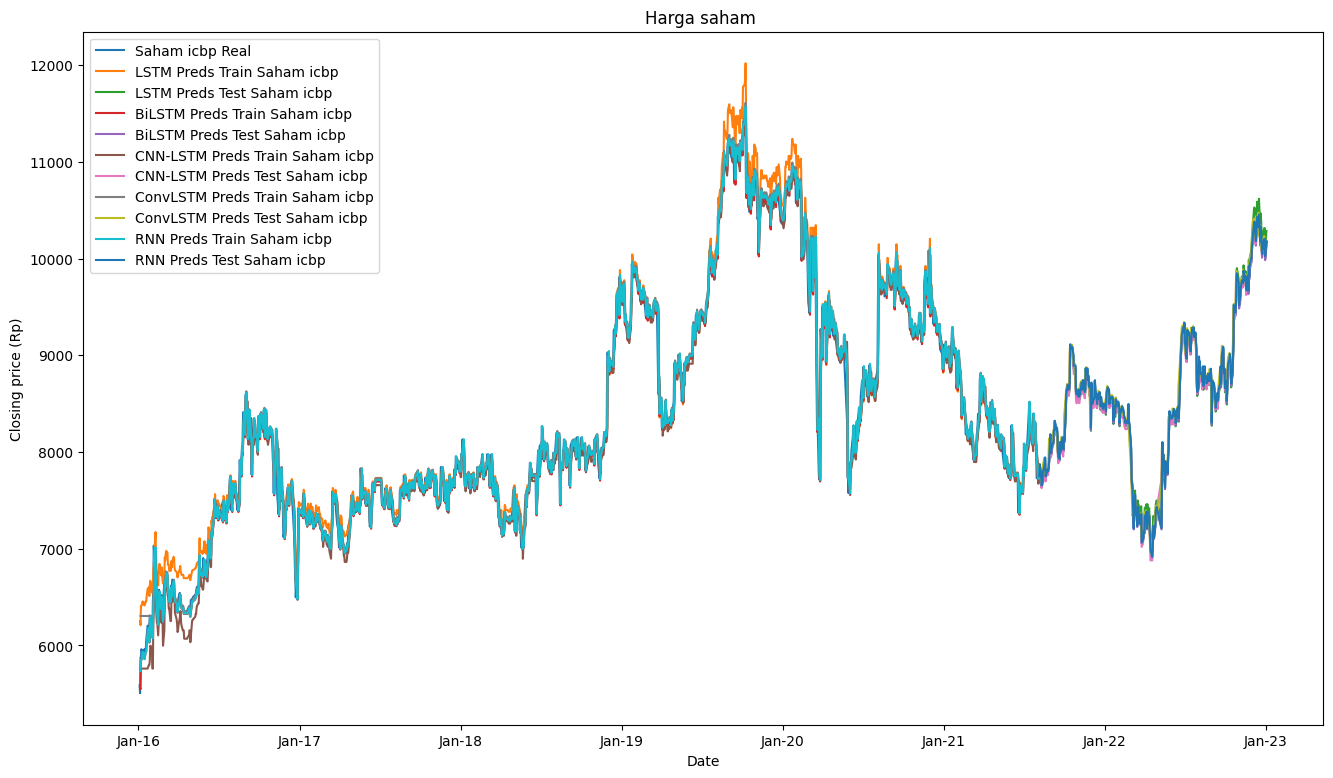

In [254]:
# Plot everything by leveraging the very powerful matplotlib package
fig, ax = plt.subplots(figsize=(16,9))
name = 'icbp'
ax.plot(icbp_data.index, icbp_data['Adj Close'], label='Saham {} Real'.format(name))
#VANILA LSTM
ax.plot(train_date_icbp_2, train_plot_icbp_2, label='LSTM Preds Train Saham {}'.format(name))
ax.plot(test_date_icbp_2, test_plot_icbp_2, label='LSTM Preds Test Saham {}'.format(name))
#BILSTM
ax.plot(train_date_icbp_2, train_plot_icbp_2_bilstm, label='BiLSTM Preds Train Saham {}'.format(name))
ax.plot(test_date_icbp_2, test_plot_icbp_2_bilstm, label='BiLSTM Preds Test Saham {}'.format(name))
#CNN-LSTM
ax.plot(train_date_icbp_2_cnnconv, train_plot_icbp_2_cnnlstm, label='CNN-LSTM Preds Train Saham {}'.format(name))
ax.plot(test_date_icbp_2_cnnconv, test_plot_icbp_2_cnnlstm, label='CNN-LSTM Preds Test Saham {}'.format(name))
#CONVLSTM
ax.plot(train_date_icbp_2_cnnconv, train_plot_icbp_2_conv, label='ConvLSTM Preds Train Saham {}'.format(name))
ax.plot(test_date_icbp_2_cnnconv, test_plot_icbp_2_conv, label='ConvLSTM Preds Test Saham {}'.format(name))
#RNN
ax.plot(train_date_icbp_2, train_plot_icbp_2_rnn, label='RNN Preds Train Saham {}'.format(name))
ax.plot(test_date_icbp_2, test_plot_icbp_2_rnn, label='RNN Preds Test Saham {}'.format(name))

# Define the date format
date_form = DateFormatter("%b-%y")
ax.xaxis.set_major_formatter(date_form)

ax.set_title('Harga saham ')
ax.set_xlabel('Date')
ax.set_ylabel('Closing price (Rp)')
ax.legend()

In [244]:
icbpReal2 = pd.DataFrame()
icbpReal2["LSTM"] = test_plot_icbp_2
icbpReal2["BiLSTM"] = test_plot_icbp_2_bilstm 
icbpReal2["CNN-LSTM"] = test_plot_icbp_2_cnnlstm 
icbpReal2["ConvLSTM"] = test_plot_icbp_2_conv 
icbpReal2["RNN"] = test_plot_icbp_2_rnn
icbpReal2.head(10)

,LSTM,BiLSTM,CNN-LSTM,ConvLSTM,RNN
0,7765.516602,7732.669922,7806.542480,7859.635742,7749.044434
1,7871.260742,7851.984863,7806.542480,7796.061035,7869.497559
2,7765.516602,7732.669922,7694.205566,7694.642578,7749.044434
3,7682.538086,7637.204590,7625.743652,7689.486328,7652.682129
4,7703.146973,7661.072266,7739.289062,7786.958496,7676.772461
5,7807.546387,7780.397949,7784.148926,7852.496582,7797.225098
6,7849.934082,7828.123047,7873.756836,7937.929199,7845.407227
7,7935.773438,7923.563477,7873.756836,7812.965332,7941.769043
8,7765.516602,7732.669922,7694.205566,7767.520996,7749.044434
9,7765.516602,7732.669922,7761.736328,7822.654297,7749.044434
